# Miniproject: Modelling the climate or the weather

Is past performance an indicator of future weather?

The whole of the code is included below with descriptions of each part and graphs aswell. 

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks: 
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain? 
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 

#importing useful modules
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from scipy.integrate import solve_ivp
import math
from scipy import linalg
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from tqdm import tqdm
from tqdm.keras import TqdmCallback

import keras_tuner as kt
import sklearn.utils

mpl.rcParams.update({'font.size': 10})
mpl.rcParams['figure.dpi']=200

#ignore warnings as code runs
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)
        
        
    def readStationsFileSave(self,fileName=None,justGSN=True):
        """Saves locations of stations to an array."""
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        coord_store = []
        for line in file:
            
            gsn=str(line[72:75], 'utf-8')
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            
            if gsn=='   ':
                continue
            coord_store.append([lat,lon,el])
        coord_store = np.array(coord_store) #converting list to array
        
        return coord_store

    
    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]

In [466]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [467]:
# Get list of station names
statNames=ghn.getStatKeyNames()


# Arbitrary number from 0 to 990
whichStat=105
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName
print(fileName)

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))

AU000005010.dly
AU000005010 is KREMSMUENSTER, Austria at 48.05, 14.1331, 383.0


52755


Text(0, 0.5, 'Temperature (C)')

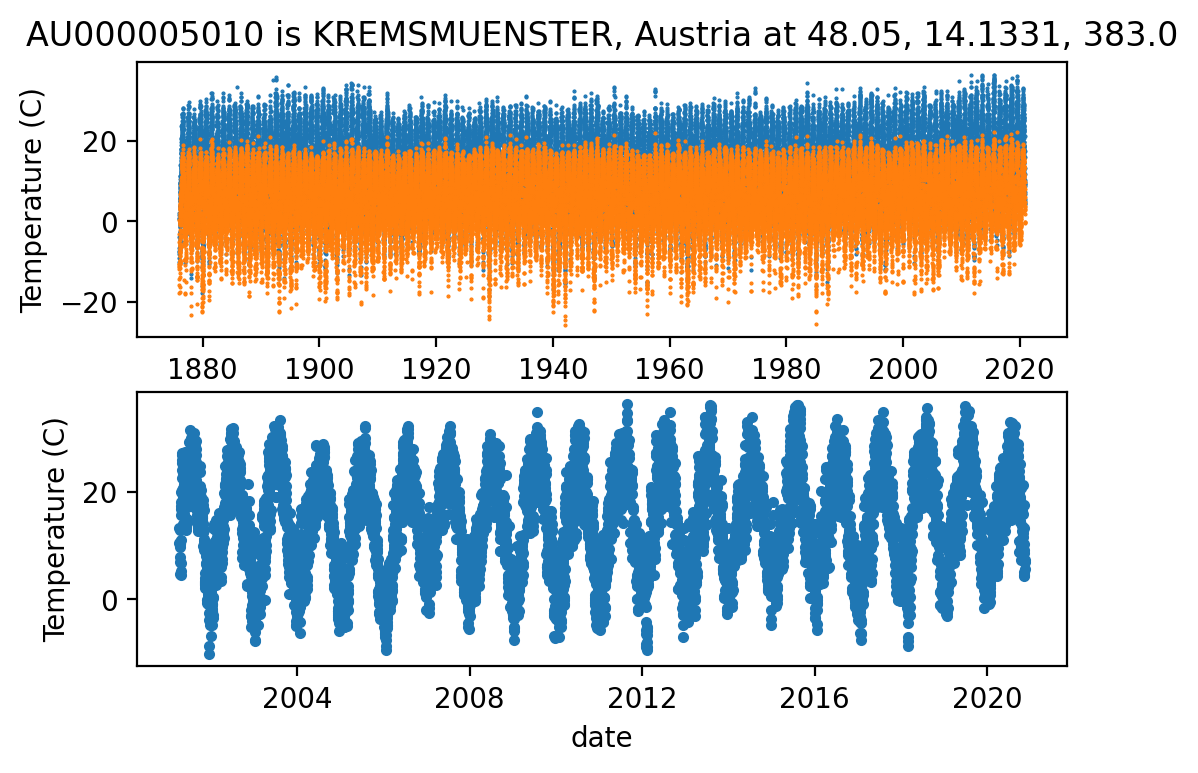

In [468]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.',markersize=1)
ax[0].plot(days2,tmin,'.',markersize=1)
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-7000:],tmax[-7000:],'.')
#ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

# Intial Tasks

## 1) Predicting the climate up to a year in advance - Climate Model
        
##### List of Avgs - this may change
- PRCP = Precipitation (tenths of mm)
- SNOW = Snowfall (mm)
- SNWD = Snow depth (mm)
- TMAX = Maximum temperature (tenths of degrees C)
- TMIN = Minimum temperature (tenths of degrees C)
- ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
- PSUN = Daily percent of possible sunshine (percent)
 

### 1 Feature NN - Inital Code

First of all start a model training with one feature from one station. This part of the code is not what was used in any of the investigation, it is a record of how the functions were developed and came to be.

In [7]:
#collate data of Tmax from one station

# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=105
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName
print(fileName)

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)

print(ghn.getStation(statNames[whichStat]))

#storing values
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)

#turning tuples into arrays 
tmax = np.array(tmax)
days = np.array(days)

AU000005010.dly
AU000005010 is KREMSMUENSTER, Austria at 48.05, 14.1331, 383.0


In [94]:
#need to reformat these to include all days with no measurements

print('Start', days[0],'End', days[-1])

#create array of all dates from start to end of data
idx = pd.date_range(days[0],days[-1])
s = pd.Series(tmax, days)
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx)

print('Before:',days.shape,'and  After:',s.shape)
print(s[0:10])

#restructuring array into weekly avg's
tmaxw = np.array(s.array) #getting array from time series
rem = len(tmaxw)%7
tmaxw = tmaxw[rem:]
tmaxw = np.reshape(tmaxw,(int(len(tmaxw)/7),7))
tmaxw_avg = np.nanmean(tmaxw,axis=1) #averaging array, ignores NaN's

print(tmaxw_avg[0:5],'Shape:', tmaxw_avg.shape)

Start 1876-01-01 End 2020-11-13
Before: (52755,) and  After: (52913,)
1876-01-01     0.6
1876-01-02     1.5
1876-01-03     2.0
1876-01-04     0.8
1876-01-05    -9.0
1876-01-06    -8.0
1876-01-07   -10.0
1876-01-08    -6.5
1876-01-09    -7.5
1876-01-10    -3.8
Freq: D, dtype: float64
[-3.15714286 -4.65714286 -1.05714286 -1.44285714 -5.2       ] Shape: (7559,)


In [95]:
def shapeArray1d(var,windowsize,offset):
    """This splits up the 1d array of different incremental position values to a 2d array of those same position
    values in overlapping windows and has the target at the end of the row"""
    
    #creating windows of data with target labels
    varInput = np.zeros((len(var)-(windowsize+offset)+1,windowsize+1))
    for i in range(len(var)-(windowsize+offset)):
            varInput[i,:-1]= var[i : i + windowsize]
            varInput[i,-1]= var[i+ windowsize+offset]
    
    return varInput

In [369]:
#creating arrays of windows and target labels
windowsize = 30
offset = 52
tmaxInput = shapeArray1d(tmaxw_avg,windowsize,offset)

In [97]:
#clear out unwanted windows with NaN in them and respective target labels
print(tmaxInput.shape)

tmaxInput_check = np.isnan(tmaxInput).any(axis=1)
tmaxInput_clean = np.delete(tmaxInput,tmaxInput_check,axis=0)

#separating data from target labels
tmaxTrain_clean = tmaxInput_clean[:,:-1]
tmaxTrain_clean = tmaxTrain_clean.reshape(len(tmaxTrain_clean[:,0]),len(tmaxTrain_clean[0,:]),1)
tmaxLabel_clean = tmaxInput_clean[:,-1:]
print(tmaxTrain_clean.shape)

(7478, 31)
(7478,)
(7414, 31)
(7414, 30, 1)


In [98]:
#place this data into training, testing and validation data

num_test = int(0.1*len(tmaxTrain_clean))

tmaxData_train = tmaxTrain_clean[:-num_test,:]
tmaxData_test = tmaxTrain_clean[-num_test:,:]
tmaxLabel_train = tmaxLabel_clean[:-num_test]
tmaxLabel_test = tmaxLabel_clean[-num_test:]
print('Test data:',tmaxData_test.shape)

#now split this training data into training and validation data
tmaxData_train, tmaxData_val, tmaxLabel_train, tmaxLabel_val = train_test_split(tmaxData_train, tmaxLabel_train, 
                                                                                random_state = 42)
print('Training data:',tmaxData_train.shape)
print('Validation data:',tmaxData_val.shape)

Test data: (741, 30, 1)
Training data: (5004, 30, 1)
Validation data: (1669, 30, 1)


In [99]:
#creating the initial model

model=keras.models.Sequential()
model.add(keras.layers.LSTM(25,input_shape=(windowsize,1),return_sequences=True))
model.add(keras.layers.LSTM(10,activation='relu',return_sequences=False))
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
model.summary()

model.save_weights('model_saves/model.1.0')

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 30, 25)            2700      
                                                                 
 lstm_57 (LSTM)              (None, 10)                1440      
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
_________________________________________________________________


In [100]:
#loading weights so the model can be re-run without including trained weights
model.load_weights('model_saves/model.1.0')

#training the model
history=model.fit(tmaxData_train,tmaxLabel_train,epochs=10,verbose=0,batch_size=32,
                  validation_data=(tmaxData_val,tmaxLabel_val),callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

The RMSE is: 3.4468


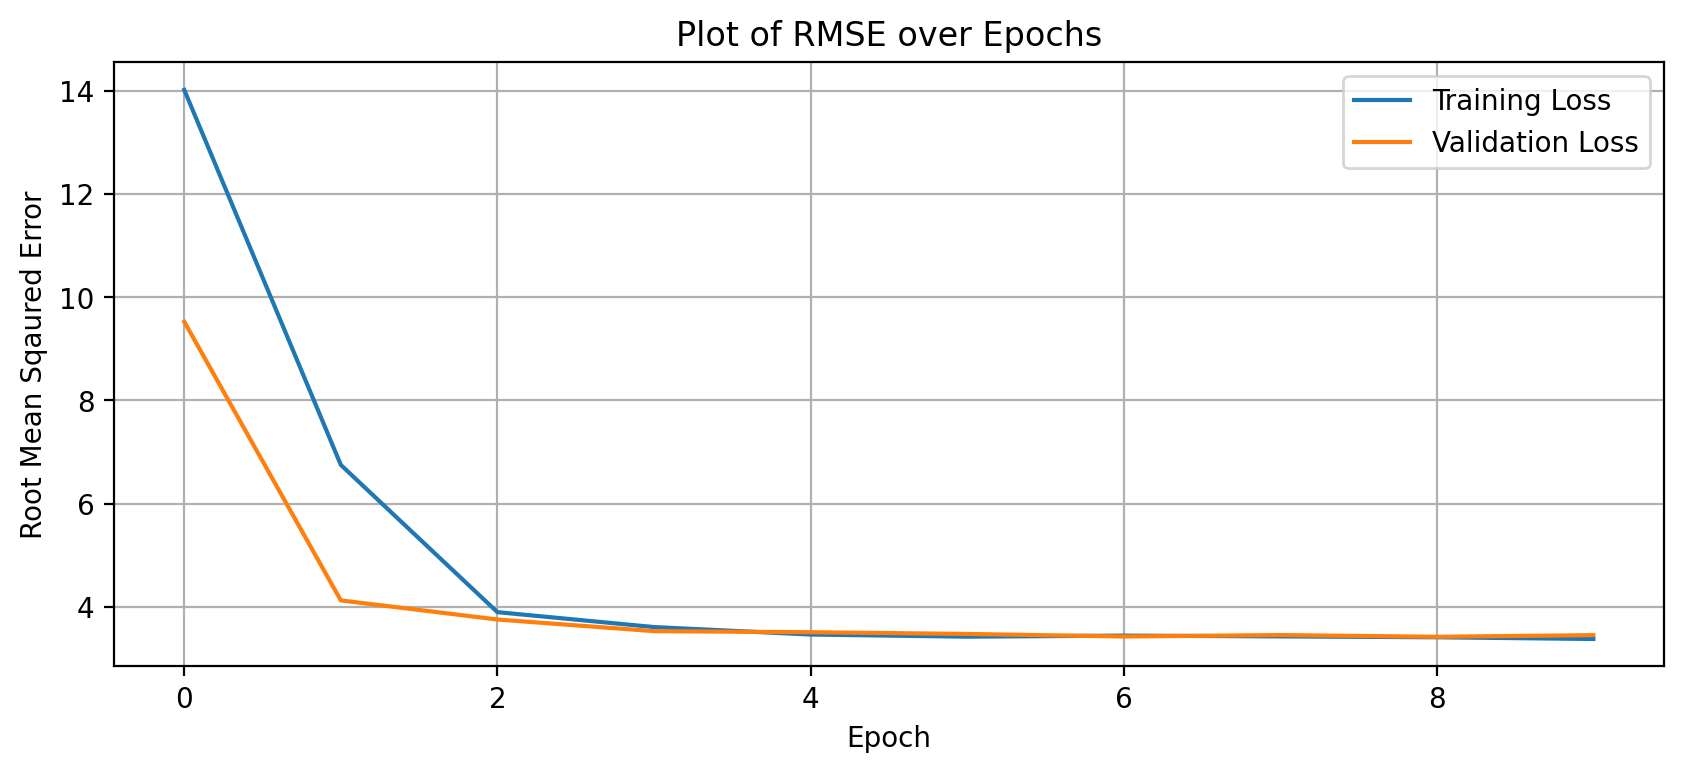

In [101]:
#plotting results
fig,ax=plt.subplots(figsize=(10,4))
ax.plot(history.history['root_mean_squared_error'],label='Training Loss')
ax.plot(history.history['val_root_mean_squared_error'],label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Root Mean Sqaured Error')
ax.set_title('Plot of RMSE over Epochs')
ax.legend()
ax.grid()

print('The RMSE is:',np.round(history.history['val_root_mean_squared_error'][-1],decimals=4) )

### Plot Results of initial code attempt for a single feature

(741, 1)


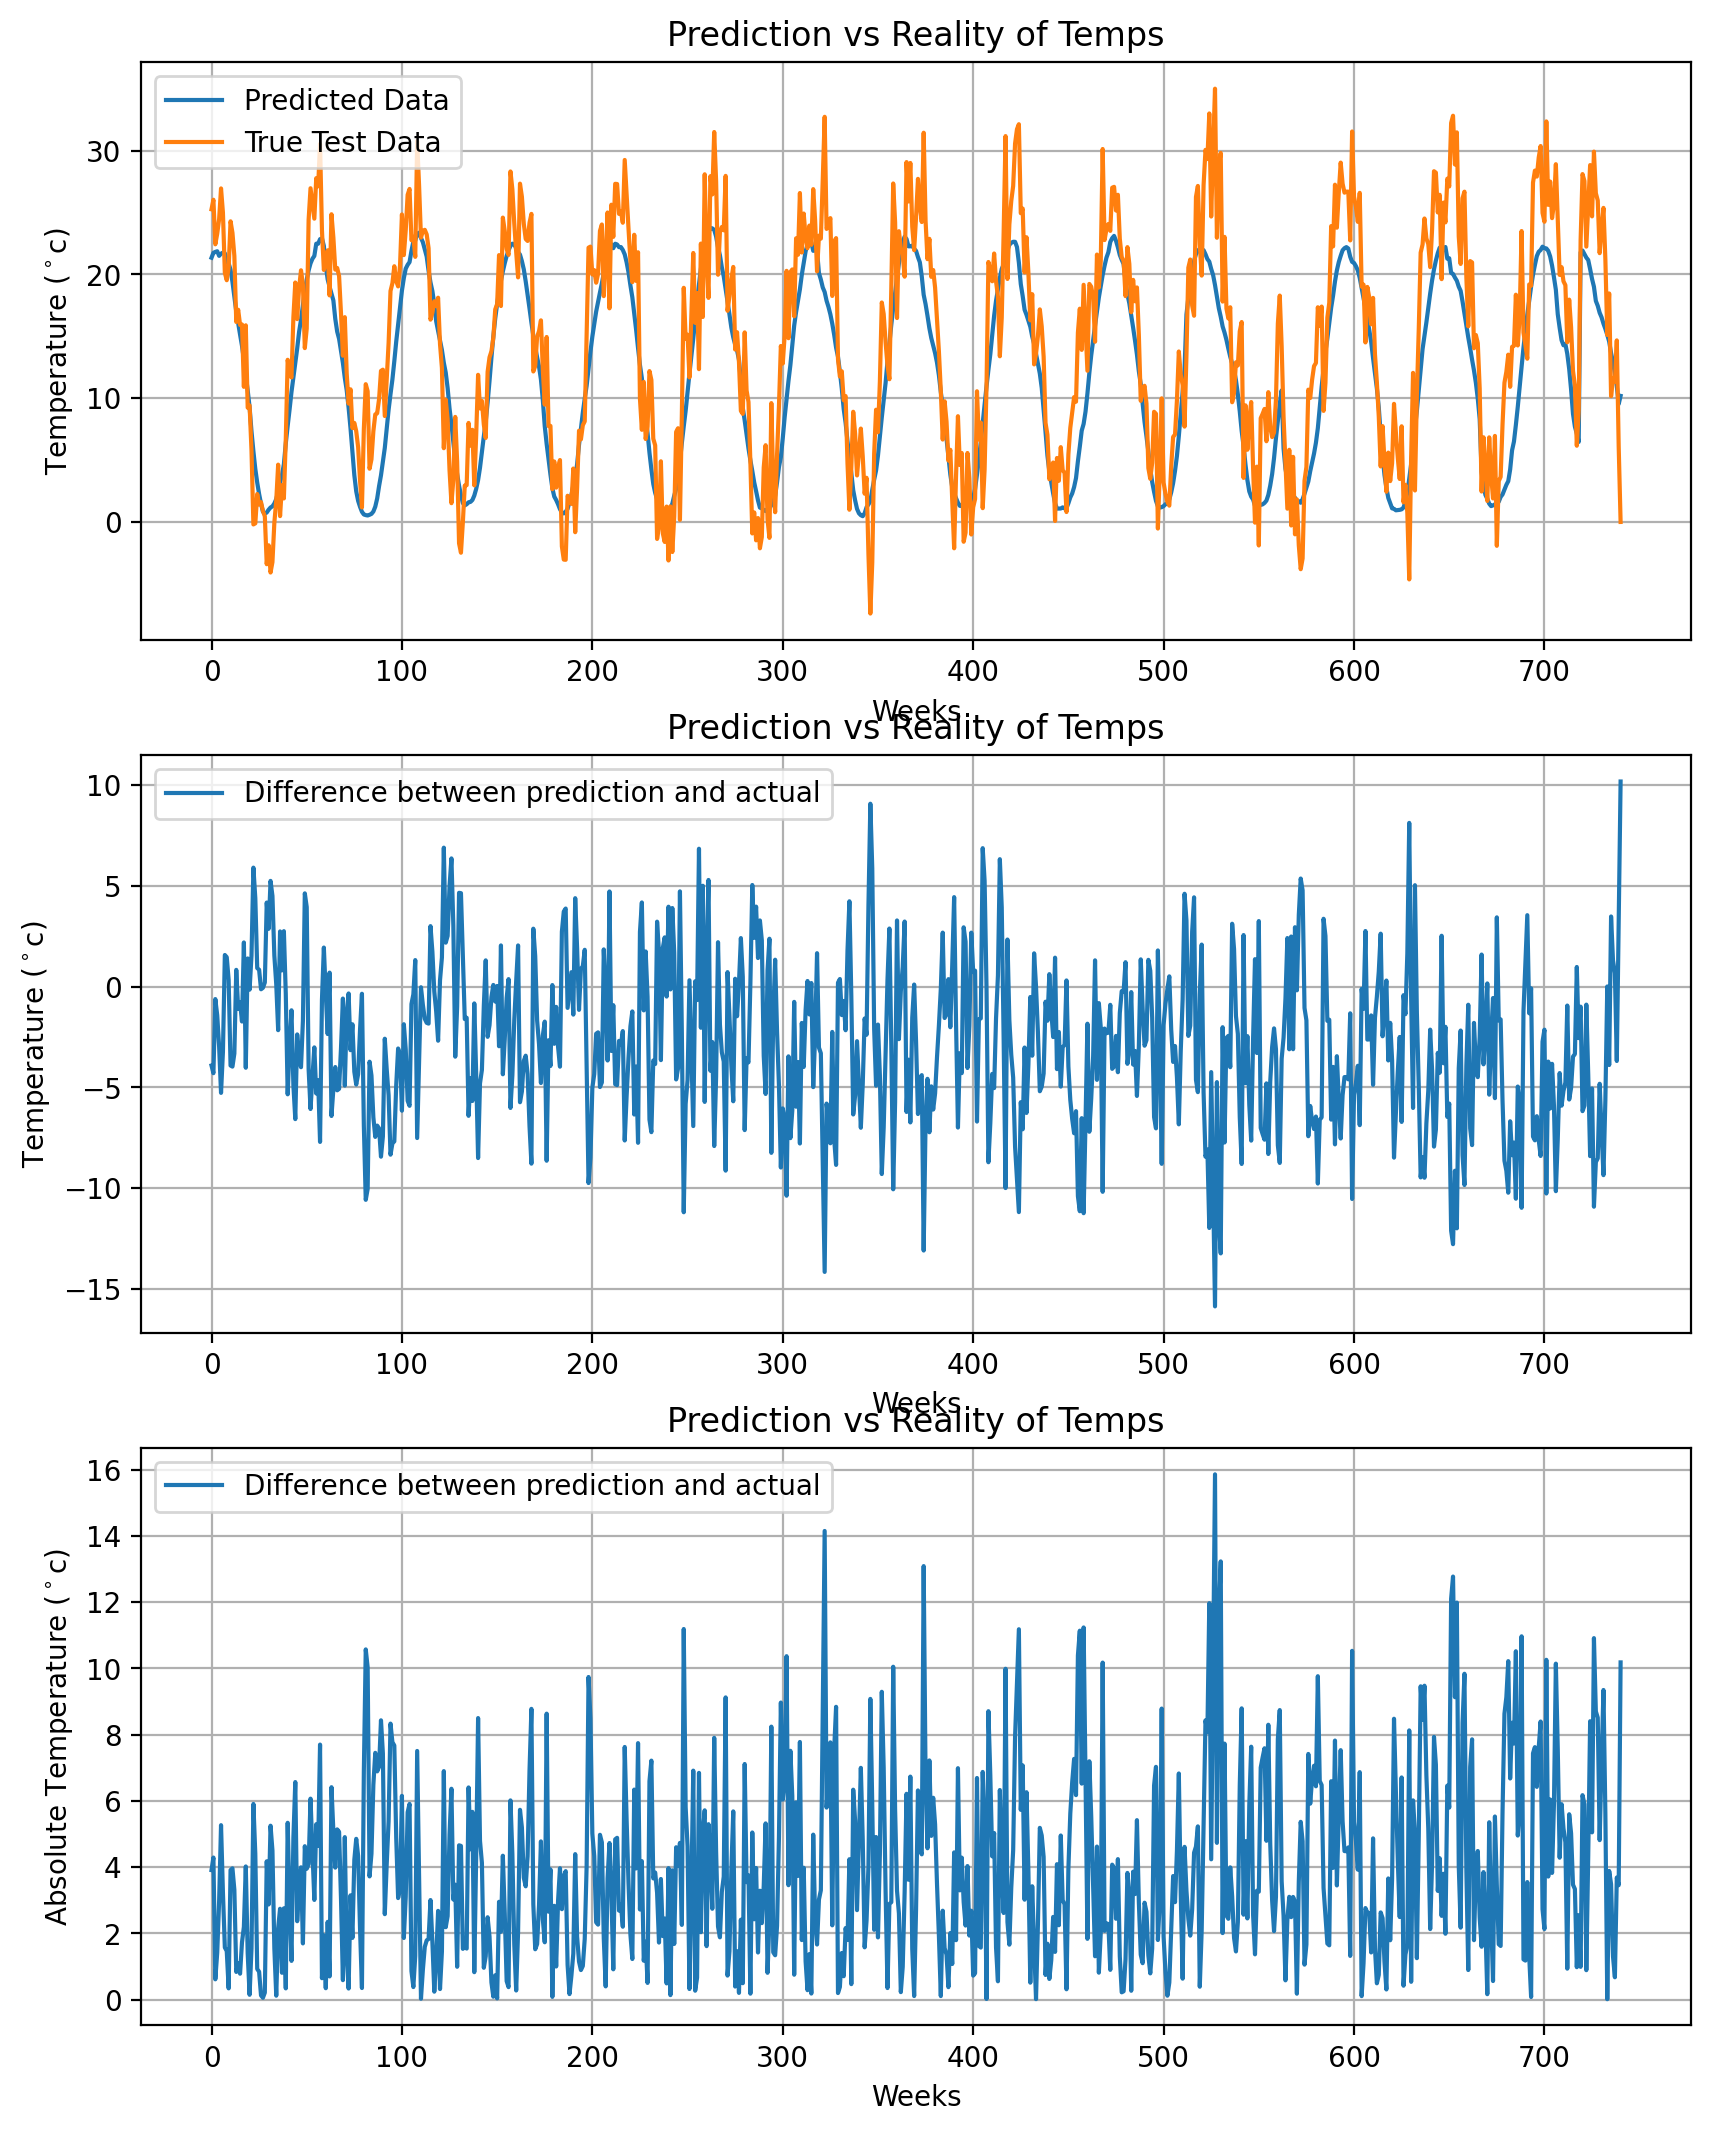

In [102]:
#test against testing set
test_predict=model.predict(tmaxData_test)
print(test_predict.shape)

#plotting useful graphs
#no offset needed in the prediction data ebacuse it is already included
fig,ax=plt.subplots(3, figsize=(10,13))
ax[0].plot(test_predict,label="Predicted Data")
ax[0].plot(tmaxLabel_test,label="True Test Data")
ax[0].set_title("Prediction vs Reality of Temps")
ax[0].set_xlabel("Weeks")
ax[0].set_ylabel("Temperature ($^\circ$c)")
ax[0].grid()
ax[0].legend()

ax[1].plot(test_predict-tmaxLabel_test,label="Difference between prediction and actual")
ax[1].set_title("Prediction vs Reality of Temps")
ax[1].set_xlabel("Weeks")
ax[1].set_ylabel("Temperature ($^\circ$c)")
ax[1].grid()
ax[1].legend()

ax[2].plot(abs(test_predict-tmaxLabel_test),label="Difference between prediction and actual")
ax[2].set_title("Prediction vs Reality of Temps")
ax[2].set_xlabel("Weeks")
ax[2].set_ylabel("Absolute Temperature ($^\circ$c)")
ax[2].grid()
ax[2].legend()

This weekly data does not describe consective weeks at all points as sometimes there is missing data and thses weeks have been ommitted. Nevertheless it does show there is an ok prediction of the temperatures a year in advance. Increasing the windowsize from 30 to 50 weeks does not seem to considerably decrease the RMSE.

### Multi-feature NN - Begining of useful Analysis

Need to restructure the code to allow it to process more data features, then going to analyse to see how this affects the error of the model.

This part of the code changes the format to include processing of more features and also changes each of the chunks of code into blocks of useful functions for formatting data and then groups these together in a conclusive function for this specific task.

In [262]:
def getVars(var_names,whichStat):
    """Allows specification of station and variables required from that station, outputs this data into arrays
    Inputs
    var_names: list of the variable name keys e.g. ['TMAX', 'PRCP']
    whichStat: Station number 0-999 from list
    Returns
    varN: dictionary of temperature arrays
    daysN: dictionary of corresponding dates arrays
    """
    
    #accessing station dictionaries
    statNames=ghn.getStatKeyNames() #get list of station names
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName
    urllib.request.urlretrieve(urlName,fileName) #copy a network object to a local file
    statDict=ghn.processFile(fileName)
    
    #error for if requested variables not included in Station Dictionary
    for i in range(len(var_names)):
        if var_names[i] not in statDict:
            print(f'Station {whichStat} doesnt have {var_names[i]} measurements.')
            return 0, 0
    
    #storing the data arrays in dictionaries
    var = {}
    days = {}
    for i in range(len(var_names)):
        store = ghn.getVar(statDict,var_names[i])
        days[i], var[i] = zip(*store)
        days[i], var[i] = np.array(days[i]), np.array(var[i])
        
    return var, days

In [263]:
def reformat_datafiles(var_names, days, var):
    """This function reformats the arrays of variables to inclue NaN elements for days where measurements 
    have not taken place, this allows all features to be compared and placed in one array
    Inputs
    var_names: 
    days: dictionary of days arrays 
    var: dictionary of variable arrays
    Returns
    data: array of all measurement values over time, with NaN 'holes' with shape (#_measurement_days,#_features)"""
    
    #creating dictionaries
    idx = {}
    s = {}
    
    #create array of all dates from start to end of data
    for i in range(len(days)):
        idx[i] = pd.date_range(days[i][0],days[i][-1])
        s[i] = pd.Series(var[i], days[i],name=var_names[i])
        s[i].index = pd.DatetimeIndex(s[i].index)
        s[i] = s[i].reindex(idx[i])

    #separating action for single and multi feature arrays
    if len(days) == 1:
        data = s[0]
    else:
        #merging into one array
        for i in range(len(days)-1):
            if i == 0:
                data = pd.merge(left=s[i],right=s[i+1],left_index=True, right_index=True)
            else:
                data = pd.merge(left=data,right=s[i+1],left_index=True, right_index=True)
        
    #outputting from pandas to numpy array
    data = data.to_numpy()
    
    return data

In [264]:
def week_avg_data(vals_daily):
    """Converts daily data into weekly averages for each feature.
    Inputs
    vals_daily: daily data values (#_measurements,#_features)
    Returns
    valsw: weekly average data vals (#_measurements/7ish,#_features)"""
    
    #adding dimension to single feature arrays
    if vals_daily.ndim == 1:
        vals_daily = np.reshape(vals_daily,(len(vals_daily),1))

    #restructuring array into weekly avg's
    n_f = len(vals_daily[0,:]) #num features
    rem = len(vals_daily[:,0])%7 #remainder
    vals_daily = vals_daily[rem:,:] 
    valsw = np.reshape(vals_daily,(int(len(vals_daily[:,0])/7),7,n_f)) #separating into weeks
    valsw_avg = np.nanmean(valsw,axis=1) #averaging array
    
    return valsw_avg

In [265]:
def shapeArray2d(var,windowsize,offset):
    """This splits up the 2d array of different incremental position values to a 3d array of those same position
    values in overlapping windows."""
    
    #creating array
    varInput = np.zeros((len(var[0,:]),len(var[:,0])-(windowsize+offset)+1,windowsize+1))
    
    #iterating over features
    for k in range(len(var[0,:])):
        #iterating over weeks
        for i in range(len(var[:,0])-(windowsize+offset)):
            varInput[k,i,:-1]= var[i : i + windowsize, k]
            varInput[k,i,-1]= var[i+ windowsize+offset, k]
    
    return varInput

In [266]:
def clean_sort(valsInput):
    """Cleans an array of windows with NaN values into two arrays of clean windows and target labels
    Inputs
    vals: has shape (num_features,num_windows,windowsize+targetval)
    Outputs
    valsTrain: (num_windows,windowsize,num_features)
    valsLabel: (num_windows,num_features)"""
    
    #identifying NaN placement
    valsInput_check = np.isnan(valsInput).any(axis=2) #creates array of True/False
    total_check = np.any(valsInput_check,axis=0) #merge all rows of True values into one row

    #deletes all respectives rows features windows where at least one feature window has a NaN value in
    valsInput_clean = np.delete(valsInput,total_check,axis=1)

    #separating data from target labels and reshaping
    valsTrain = np.moveaxis(valsInput_clean[:,:,:-1], 0, -1)
    valsLabel = np.moveaxis(valsInput_clean[:,:,-1], 0, -1)
    
    return valsTrain, valsLabel

In [267]:
def separate_data(valsData_clean,valsLabel_clean,ratio):
    """This function takes in window and target label data arrays and splits them into training, testing
    and validation datasets.
    
    Inputs
    ratio: ratio final consecutive data to include
    valsData_clean: (num_windows,windowsize,num_features)
    valsLabel_clean: (num_windows,num_features)
    
    Returns
    vals: dictionary containing Data and Target label arrays, with respective shapes:
        data: (num_windows,windowsize,num_features)
        label: (num_windows,num_features)
        vals[valsData_train, valsLabel_train, valsData_val, valsLabel_val, valsData_test, valsLabel_test, 
        valsData_conseq, valsLabel_conseq]
    """
    
    #place this data into training, testing and validation data
    num_test = int(ratio*len(valsData_clean[:,0,0]))
    
    #creating dictionary
    vals = {}
    
    #storing consecutive data for plots
    vals[6] = valsData_clean[-num_test:]    #valsData_test
    vals[7] = valsLabel_clean[-num_test:]   #valsLabel_test

    #separating out test data
    vals[0], vals[4], vals[1], vals[5] = train_test_split(valsData_clean, valsLabel_clean, test_size=0.1, 
                                                      random_state=42)
    #separating into training and validation data
    vals[0], vals[2], vals[1], vals[3] = train_test_split(vals[0], vals[1], random_state=42)
    
    return vals

In [268]:
def separate_data_last10(valsData_clean,valsLabel_clean,ratio):
    """This function takes in window and target label data arrays and splits them into training, testing
    and validation datasets.
    
    Inputs
    ratio: ratio final consecutive data to include
    valsData_clean: (num_windows,windowsize,num_features)
    valsLabel_clean: (num_windows,num_features)
    
    Returns
    vals: dictionary containing Data and Target label arrays, with respective shapes:
        data: (num_windows,windowsize,num_features)
        label: (num_windows,num_features)
        vals[valsData_train, valsLabel_train, valsData_val, valsLabel_val, valsData_test, valsLabel_test, 
        valsData_conseq, valsLabel_conseq]
    """
    
    #place this data into training, testing and validation data
    num_test = int(ratio*len(valsData_clean[:,0,0]))
    
    #creating dictionary
    vals = {}
    
    #separating into test and train
    vals[0] = valsData_clean[:-num_test] #valsData_train
    vals[1] = valsLabel_clean[:-num_test]  #valsLabel_train
    vals[4] = valsData_clean[-num_test:]    #valsData_test
    vals[5] = valsLabel_clean[-num_test:]   #valsLabel_test
    
    #now split this training data into training and validation data
    vals[0], vals[2], vals[1], vals[3] = train_test_split(vals[0], vals[1], random_state = 42)
    
    return vals

In [269]:
def getNNData_weekavg_last10(var_names,whichStat,windowsize,offset,ratio_test):
    """Takes specification of data required and outputs datasets which may train a neural network, takes daily
    measurement and formats them to weekly averages. 
    Taking all previous functions and places them into one.
    
    Inputs
    var_names: list of variable names
    whicStat: station number 0-999
    windowsize: size of LSTM window
    offset: offset of target labels
    ratio_test: ratio of test data to whole dataset
    
    Returns
    vals: dictionary containing Data and Target label arrays
            valsData_train = vals[0]
            valsLabel_train = vals[1]
            valsData_val = vals[2]
            valsLabel_val = vals[3]
            valsData_test = vals[4]
            valsLabel_test  = vals[5]
            valsLabel_conseq  = vals[6]
            valsLabel_conseq  = vals[7]"""
    
    #getting raw measurement from station dictionary
    var, days = getVars(var_names,whichStat)
    
    #error for data missing from last feature
    if var[len(var_names)-1].shape[0] < 0.01*var[0].shape[0]:
        print(f'Station {whichStat} Missing large amounts of data for final feature.')
        return 0

    #reformatting data into one array with holes where no measurements were taken
    vals_daily = reformat_datafiles(var_names,days,var)

    #reformatting to weekly average
    valsw_avg = week_avg_data(vals_daily)

    #creating windows
    valsInput = shapeArray2d(valsw_avg,windowsize,offset)

    #cleaning data from Nan Values
    valsTrain_clean, valsLabel_clean = clean_sort(valsInput)
    
    #if statements for functions with too many holes in data
    if valsTrain_clean.shape[0] < 0.01*valsInput.shape[1]:
        print(f"Station {whichStat}'s data cannot be cleaned due to high frequency of holes in data.")
        return 0

    #seprating data into groups
    vals = separate_data_last10(valsTrain_clean, valsLabel_clean,ratio_test)
    
    return vals

In [296]:
def getNNData_weekavg(var_names,whichStat,windowsize,offset,ratio_test,decrease_train = True):
    """Takes specification of data required and outputs datasets which may train a neural network, takes daily
    measurement and formats them to weekly averages. 
    Taking all previous functions and places them into one.
    
    Inputs
    var_names: list of variable names
    whicStat: station number 0-999
    windowsize: size of LSTM window
    offset: offset of target labels
    ratio_test: ratio of test data to whole dataset
    decrease_train: variable to automatically decrease the size of the training set to improve performance
    
    Returns
    vals: dictionary containing Data and Target label arrays
            valsData_train = vals[0]
            valsLabel_train = vals[1]
            valsData_val = vals[2]
            valsLabel_val = vals[3]
            valsData_test = vals[4]
            valsLabel_test  = vals[5]
            valsLabel_conseq  = vals[6]
            valsLabel_conseq  = vals[7]"""
    
    #getting raw measurement from station dictionary
    var, days = getVars(var_names,whichStat)
    
    #error for data missing from last feature
    if var[len(var_names)-1].shape[0] < 0.01*var[0].shape[0]:
        print(f'Station {whichStat} Missing large amounts of data for final feature.')
        return 0

    #reformatting data into one array with holes where no measurements were taken
    vals_daily = reformat_datafiles(var_names,days,var)

    #reformatting to weekly average
    valsw_avg = week_avg_data(vals_daily)
    
    #creating windows
    valsInput = shapeArray2d(valsw_avg,windowsize,offset)

    #cleaning data from Nan Values
    valsTrain_clean, valsLabel_clean = clean_sort(valsInput)
    
    #if statements for functions with too many holes in data
    if valsTrain_clean.shape[0] < 0.01*valsInput.shape[1]:
        print(f"Station {whichStat}'s data cannot be cleaned due to high frequency of holes in data.")
        return 0

    #seprating data into groups
    vals = separate_data(valsTrain_clean, valsLabel_clean,ratio_test)
    
    #decreasing size of training set to 3500 windows
    if decrease_train == True:
        for i in range(2):
            vals[i] = vals[i][:3500]
    
    return vals

In [271]:
def RMSD(data,labels):
    """Finds the root mean squared deviation between two datsets."""
    
    diff = labels-data
    rmsd = np.sqrt(np.average(diff*diff,axis=0))
    
    return rmsd

Use a model structure that has been optimized through trial and error.

In [399]:
def weekly_model(vals,windowsize,var_names):
    """This creates, compiles and trains a model on a dataset of average weekly values of climate values and
    gives the resulting relevant accuracy values as well as the trained model.
    Inputs
    vals: dictionary of datasets
    windowsize: windowsize of the training data
    var_names: list of the names of the features
    Returns
    history: stored values specified as the model is trained
    model: keras model trained on inputted data"""
    
    n_features = len(var_names)
    
    #creating model structure
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(40,input_shape=(windowsize,n_features),return_sequences=True))
    model.add(keras.layers.LSTM(20,activation='relu',return_sequences=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(n_features,activation="linear"))
    model.compile(loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
    
    #fitting the model to the data
    history=model.fit(vals[0],vals[1],epochs=5,verbose=0,batch_size=32,
                  validation_data=(vals[2],vals[3])) # callbacks=[TqdmCallback(verbose=0)])
    
    return history, model

### Training Climate Model

Below the optimisation of the climate model egins using various methods.

In [137]:
#setting and storing values
var_names = ['TMAX', 'TMIN', 'PRCP']
whichStat = 105
mwindowsize = 30
moffset = 52
ratio = 0.1

#reformatting data into datasets
vals2 = getNNData_weekavg(var_names,whichStat,mwindowsize,moffset,ratio)

#training model
history2, model2 = weekly_model(vals2,mwindowsize,var_names)

The RMSE is: 3.0668


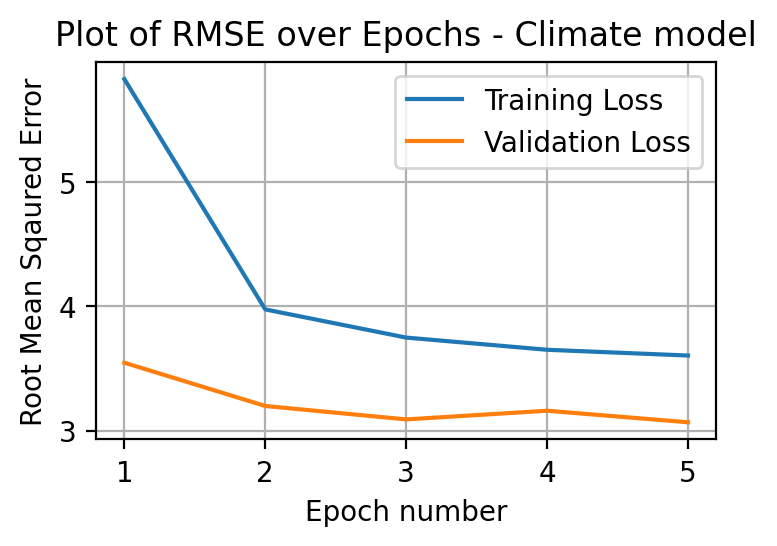

In [471]:
#plotting results
fig,ax=plt.subplots(figsize=(4,2.5))
x = np.arange(0,len(history2.history['root_mean_squared_error']))+1
ax.plot(x,history2.history['root_mean_squared_error'],label='Training Loss')
ax.plot(x,history2.history['val_root_mean_squared_error'],label='Validation Loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Root Mean Sqaured Error')
ax.set_title('Plot of RMSE over Epochs - Climate model')
ax.legend()
ax.grid()

print('The RMSE is:',np.round(history2.history['val_root_mean_squared_error'][-1],decimals=4) )

#set weekly epoch value
epochsw = 5

#### Exploring the effect on RMSE of varying Dataset size for the network to train on

Note: throughtout the rest of this notebook a series of averaging codes are used to display graphs, these were attempted to be place into a singular function, however due to the variability of the models and functions required for each of the graph it did not make sense in terms of time investment to develop such a complex function.

In [180]:
amount_of_data = np.array([0.05,0.1,0.2,0.4,0.7,1]) #variations in windowsize
num_avgs = 10 #number of trainings to avg over
RMSE_amount = np.zeros((len(amount_of_data),num_avgs))

#loop to find avg of RMSE
for i in range(len(amount_of_data)):
    vals = getNNData_weekavg(var_names,whichStat,mwindowsize,moffset,ratio,decrease_train=False) #formatting data
    
    for num in range(2): #changing length of training datasets
        vals[num] = vals[num][:int(amount_of_data[i]*len(vals[num]))]
        
    for j in range(num_avgs): #average this variation
        history, model = weekly_model(vals,mwindowsize,var_names) #creating and training model
        RMSE_amount[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
RMSE_amount_avg = np.average(RMSE_amount,axis=1)
sd_amount = np.sqrt(np.var(RMSE_amount,axis=1))

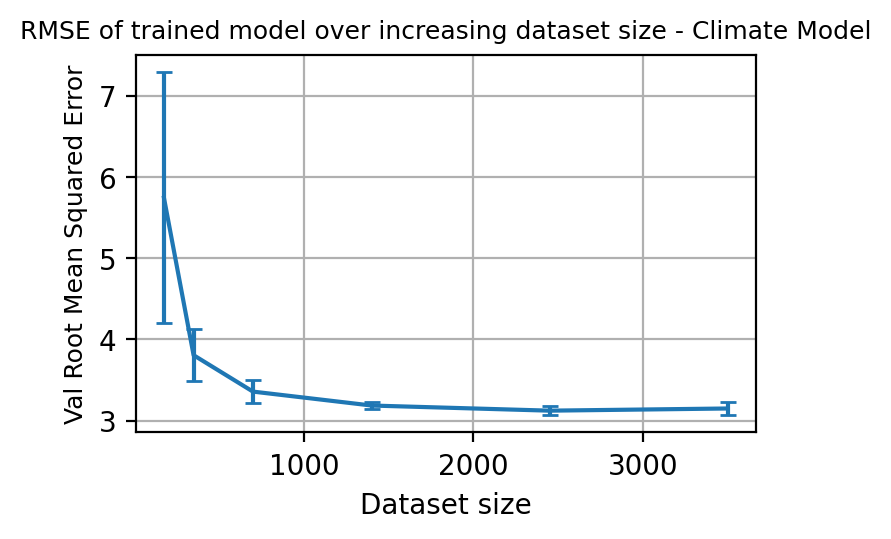

In [478]:
#plotting results
vals = getNNData_weekavg(var_names,whichStat,mwindowsize,moffset,ratio) 
plt.subplots(figsize=(4,2.5))
plt.errorbar(np.round(amount_of_data*len(vals[0])),RMSE_amount_avg,yerr=sd_amount, capsize=3)
plt.title('RMSE of trained model over increasing dataset size - Climate Model',fontsize=9)
plt.ylabel('Val Root Mean Squared Error',fontsize=9)
plt.xlabel('Dataset size')
plt.grid()

In [218]:
#analysis of the model
improvement = np.round(((RMSE_amount_avg[-3]-RMSE_amount_avg[-2])/RMSE_amount_avg[-3])*100,decimals=3)
dataincrease = np.round((3400/1900)*100-100,decimals=3)
print('There is a',improvement,'% improvement in performance of the model for a',dataincrease,'% increase in the amount of data.')

There is a 1.977 % improvement in performance of the model for a 78.947 % increase in the amount of data.


From the above graph it is possible to see that the performance, as defined by val RMSE, of the network does not increase much after a dataset size of around 3000 windows and infact gets slightly worse as the number of windows increases. As a result of this the getNNData_weekavg function will be updated to decrease the size of the training dataset to 3500 windows.

#### Number of Features

Comparing the performance of the model with differing numbers of features added.

In [426]:
var_names_change = [['TMAX'],['TMIN'],['PRCP']]
num_avgs = 10 #number of trainings to avg over
RMSE_features = np.zeros((len(var_names_change),num_avgs))
RMSE_predict = np.zeros((num_avgs,len(var_names)))

#loop to find avg of RMSE, individual features
for i in range(len(var_names_change)):
    for j in range(num_avgs):
        vals = getNNData_weekavg(var_names_change[i],whichStat,mwindowsize,moffset,ratio) #formatting data
        history, model = weekly_model(vals,mwindowsize,var_names_change[i]) #creating and training model
        vals_RMSEw = model.predict(vals[4],batch_size = 32)
        RMSE_features[i,j] = RMSD(vals_RMSEw,vals[5])
        
#predictions from grouped features
for i in range(num_avgs):
        vals_all = getNNData_weekavg(var_names,whichStat,mwindowsize,moffset,ratio) #formatting data
        history, model = weekly_model(vals_all,mwindowsize,var_names) #creating and training model
        vals_predictw = model.predict(vals_all[4],batch_size = 32)
        RMSE_predict[i,:] = RMSD(vals_predictw,vals_all[5])
        
RMSE_features_avg = np.average(RMSE_features,axis=1)
RMSE_predict_avg = np.average(RMSE_predict,axis=0)

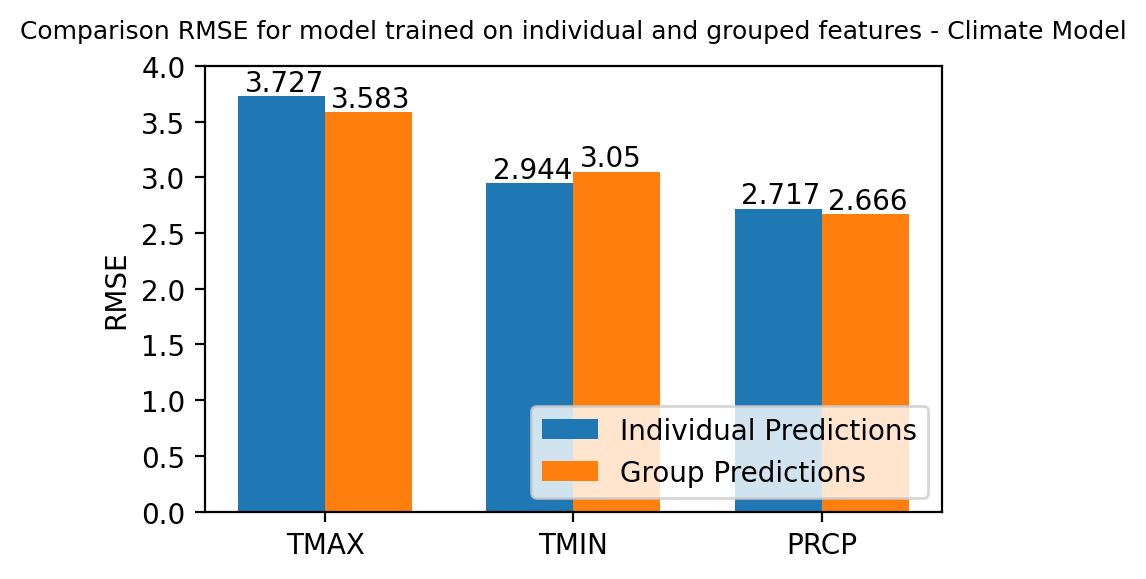

In [527]:
#plotting results

x = np.arange(len(var_names))  # the label locations
width = 0.35  # the width of the bars

#plotting bars
fig, ax = plt.subplots(figsize=(4.5,3))
rect1 = ax.bar(x - width/2, RMSE_features_avg, width, label='Individual Predictions')
rect2 = ax.bar(x + width/2, RMSE_predict_avg, width, label='Group Predictions')

#labelling top of bars
for i, x_val in enumerate(x):
    ax.text((x_val - width/2-0.15), RMSE_features_avg[i]+0.05, str(np.round(RMSE_features_avg[i],decimals=3)))
    ax.text((x_val + width/2-0.15), RMSE_predict_avg[i]+0.05, str(np.round(RMSE_predict_avg[i],decimals=3)))

# setting out the graph
ax.set_ylabel('RMSE')
ax.set_title('Comparison RMSE for model trained on individual and grouped features - Climate Model',fontsize=9, pad=10)
ax.set_xticks(x)
ax.set_ylim(0,4)
ax.set_xticklabels(var_names)
ax.legend(loc='lower right')
fig.tight_layout()

#### Windowsize

Comparing the performance of the model for different windowsizes.

In [62]:
mwindowsize_var = np.array([10,30,40,50,60,80,100]) #variations in windowsize
num_avgs = 10 #number of trainings to avg over
RMSE_windows = np.zeros((len(mwindowsize_var),num_avgs))

#loop to find avg of RMSE
for i in range(len(mwindowsize_var)):
    vals = getNNData_weekavg(var_names,whichStat,mwindowsize_var[i],moffset,ratio) #formatting data
    for j in range(num_avgs): #average this variation
        history, model = weekly_model(vals,mwindowsize_var[i],var_names) #creating and training model
        RMSE_windows[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
RMSE_windows_avg = np.average(RMSE_windows,axis=1)
sd_windows = np.sqrt(np.var(RMSE_windows,axis=1))

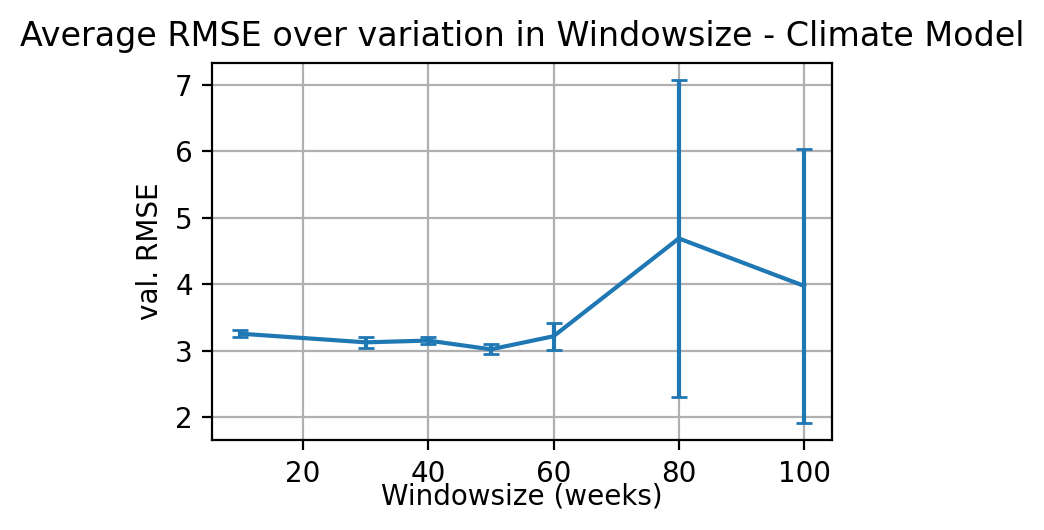

In [496]:
#plotting rmse over windowsize
fig, ax = plt.subplots(figsize=(4,2.5))
ax.errorbar(mwindowsize_var,RMSE_windows_avg,yerr=sd_windows,capsize =3)
ax.set_ylabel('val. RMSE')
ax.set_xlabel('Windowsize (weeks)', labelpad=-2)
ax.set_title('Average RMSE over variation in Windowsize - Climate Model')
ax.grid()

#setting optimum windowsize
mwindowsize_opt = 50

### Keras Tuner
Using Keras Tuner to tune the hyperparameters of the model.

In [686]:
#reformatting data into datasets
vals3 = getNNData_weekavg(var_names,whichStat,mwindowsize_opt,moffset,ratio)

In [688]:
def build_model_weekly(hp):
    """Building the Keras tuner model"""
    
    model = keras.models.Sequential()
    
    #adding lstm layers
    model.add(keras.layers.LSTM(hp.Int('lstm_0_unit',min_value=10,max_value=100,step=10),return_sequences=True, input_shape=(vals3[0].shape[1],vals3[0].shape[2])))
    for i in range(hp.Int('n_lstm_layers', 0, 2)):
        model.add(keras.layers.LSTM(hp.Int(f'lstm_{i+1}_units',min_value=10,max_value=70,step=10),return_sequences=True))
    model.add(keras.layers.LSTM(hp.Int('lstm_final_units',min_value=10,max_value=70,step=10)))
    
    #dropout layer
    model.add(keras.layers.Dropout(hp.Float('dropout_rate1',min_value=0,max_value=0.5,step=0.1)))
    
    #dense layer
    for i in range(hp.Int('n_dense_drop_layers', 0, 2)):
        model.add(keras.layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=10, max_value=50, step=10),activation=hp.Choice(f'dense_activation{i}',values=['relu', 'sigmoid','linear'],default='relu')))
    
    #dropout layer
    model.add(keras.layers.Dropout(hp.Float(f'dropout_rate2',min_value=0,max_value=0.5,step=0.1)))
    
    #output layer
    model.add(keras.layers.Dense(vals3[1].shape[1], activation=hp.Choice('dense_activation_final',values=['relu', 'sigmoid','linear'],default='linear')))
    model.compile(loss='mse', optimizer='adam',metrics = [tf.keras.metrics.RootMeanSquaredError()])
    return model

In [689]:
#creating tuner object
tuner_weekly = kt.Hyperband(build_model_weekly,
                     objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=13,
                     directory='hypertune_dir',
                     project_name='weekly_model',
                     overwrite = True)

#routine to stop training if val rmse does not improve after 3 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)

#showing the structure of the hyperparameters
tuner_weekly.search_space_summary()

Search space summary
Default search space size: 7
lstm_0_unit (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
n_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lstm_final_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 70, 'step': 10, 'sampling': None}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
n_dense_drop_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation_final (Choice)
{'default': 'linear', 'conditions': [], 'values': ['relu', 'sigmoid', 'linear'], 'ordered': False}


In [691]:
def build_model_weekly1(hp):
    """Building the Keras tuner model"""
    
    model = keras.models.Sequential()
    
    #adding lstm layers
    model.add(keras.layers.LSTM(hp.Int('lstm_0_unit',min_value=10,max_value=100,step=10),return_sequences=True, input_shape=(vals3[0].shape[1],vals3[0].shape[2])))
    for i in range(hp.Int('n_lstm_layers', 0, 2)):
        model.add(keras.layers.LSTM(hp.Int(f'lstm_{i+1}_units',min_value=10,max_value=70,step=10),return_sequences=True))
    model.add(keras.layers.LSTM(hp.Int('lstm_final_units',min_value=10,max_value=70,step=10)))
    
    #dropout layer
    model.add(keras.layers.Dropout(hp.Float('dropout_rate1',min_value=0,max_value=0.5,step=0.1)))
    
    #dense layer
    for i in range(hp.Int('n_dense_drop_layers', 0, 2)):
        model.add(keras.layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=10, max_value=50, step=10),activation=hp.Choice(f'dense_activation{i}',values=['relu', 'sigmoid','linear'],default='relu')))
        #dropout layer
        model.add(keras.layers.Dropout(hp.Float(f'dropout_rate{i}',min_value=0,max_value=0.5,step=0.1)))
    
    #output layer
    model.add(keras.layers.Dense(vals3[1].shape[1], activation=hp.Choice('dense_activation_final',values=['relu', 'sigmoid','linear'],default='linear')))
    model.compile(loss='mse', optimizer='adam',metrics = [tf.keras.metrics.RootMeanSquaredError()])
    return model

In [692]:
#creating tuner object
tuner_weekly1 = kt.Hyperband(build_model_weekly1,
                     objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=13,
                     directory='hypertune_dir',
                     project_name='weekly_model',
                     overwrite = True)

#routine to stop training if val rmse does not improve after 3 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)

#showing the structure of the hyperparameters
tuner_weekly1.search_space_summary()

Search space summary
Default search space size: 6
lstm_0_unit (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
n_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lstm_final_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 70, 'step': 10, 'sampling': None}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
n_dense_drop_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
dense_activation_final (Choice)
{'default': 'linear', 'conditions': [], 'values': ['relu', 'sigmoid', 'linear'], 'ordered': False}


In [693]:
#running the tuner
tuner_weekly1.search(vals3[0], vals3[1], epochs=10,validation_data=(vals3[2],vals3[3]), callbacks=[stop_early])

Trial 390 Complete [00h 00m 49s]
val_root_mean_squared_error: 9.794952392578125

Best val_root_mean_squared_error So Far: 2.894986391067505
Total elapsed time: 05h 29m 52s
INFO:tensorflow:Oracle triggered exit


In [694]:
#getting best hyperparamter results
best_hps1=tuner_weekly1.get_best_hyperparameters(num_trials=1)[0]
tuner_weekly1.results_summary(num_trials=1)

model_weekly_opt = tuner_weekly1.hypermodel.build(best_hps1)

Results summary
Results in hypertune_dir\weekly_model
Showing 1 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
lstm_0_unit: 90
n_lstm_layers: 1
lstm_final_units: 40
dropout_rate1: 0.30000000000000004
n_dense_drop_layers: 0
dense_activation_final: linear
lstm_1_units: 30
dense_0_units: 20
dense_activation0: linear
dropout_rate0: 0.1
lstm_2_units: 40
dense_1_units: 30
dense_activation1: relu
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 2.894986391067505


In [695]:
model_weekly_opt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 90)            33840     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 30)            14520     
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 59,843
Trainable params: 59,843
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#NOTE: I accidentaly cut this and didnt have time to run the code through again

#variations in batchsize
batch_size_var = np.array([16,32,64,128,256])

num_avgs = 10 #number of trainings to avg over
RMSE_batches = np.zeros((len(batch_size_var),num_avgs)) #creating array for storage

#getting datasets
vals5 = getNNData_weekavg(var_names,whichStat,mwindowsize_opt,moffset,ratio)

#loop to find avg of RMSE
for i in range(len(batch_size_var)):
    for j in range(num_avgs):
        model_weekly_opt = tuner_weekly.hypermodel.build(best_hps)
        history=model_weekly_opt.fit(vals5[0],vals5[1],epochs=epochsw,verbose=0,batch_size=batch_size_var[i],
                            validation_data=(vals5[2],vals5[3]))
        RMSE_batches[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val

#getting averages and S.D.'s
RMSE_batches_avg = np.average(RMSE_batches,axis=1)
sd_batches = np.sqrt(np.var(RMSE_batches,axis=1))

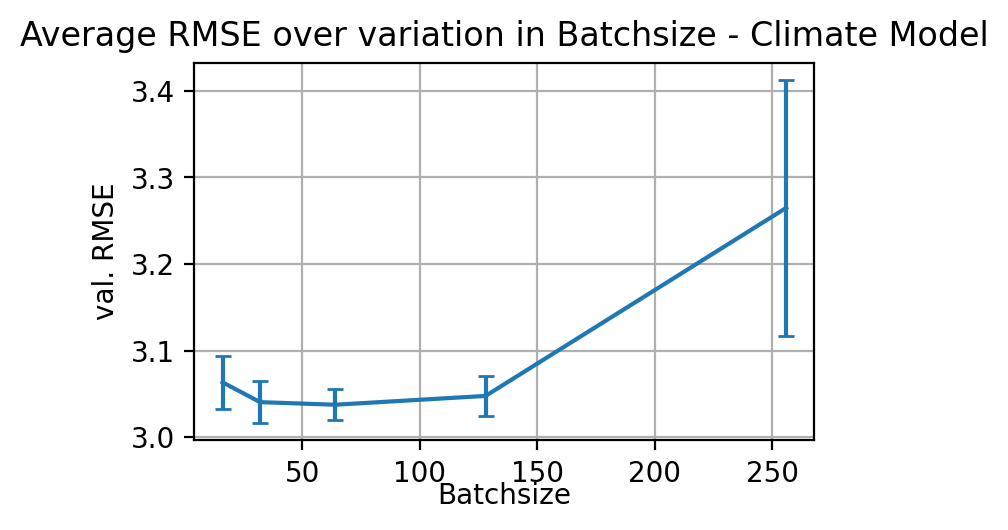

In [497]:
#plotting average RMSE over varying batchsize
fig, ax = plt.subplots(figsize=(4,2.5))
ax.errorbar(batch_size_var,RMSE_batches_avg,yerr=sd_batches,capsize =3)
ax.set_ylabel('val. RMSE')
ax.set_xlabel('Batchsize', labelpad=-2)
ax.set_title('Average RMSE over variation in Batchsize - Climate Model')
ax.grid()

#saving optimum batchsize
batch_sizew_opt = 64

#### Plotting over Epochs

In [74]:
#getting datasets
valsw_opt = getNNData_weekavg(var_names,whichStat,mwindowsize_opt,moffset,ratio)

#resetting model
model_weekly_opt = tuner_weekly.hypermodel.build(best_hps)
historyw_opt=model_weekly_opt.fit(valsw_opt[0],valsw_opt[1],epochs=epochsw,verbose=0,batch_size=batch_sizew_opt,
                  validation_data=(valsw_opt[2],valsw_opt[3]), callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

The RMSE is: 3.0482


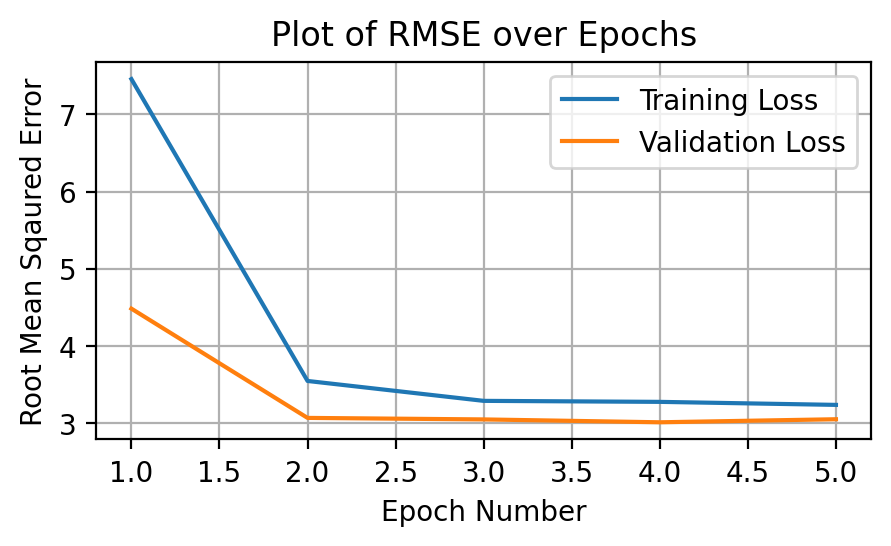

In [500]:
#plotting results over the epochs to find optimum epochs
fig,ax=plt.subplots(figsize=(5,2.5))
x = np.arange(0,len(historyw_opt.history['root_mean_squared_error']))+1
ax.plot(x,historyw_opt.history['root_mean_squared_error'],label='Training Loss')
ax.plot(x,historyw_opt.history['val_root_mean_squared_error'],label='Validation Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Root Mean Sqaured Error')
ax.set_title('Plot of RMSE over Epochs')
ax.legend()
ax.grid()

print('The RMSE is:',np.round(historyw_opt.history['val_root_mean_squared_error'][-1],decimals=4) )
#set weekly epochs optimum value
epochsw_opt = 5

### Plotting Predictions

Using the final consecutive dataset that has data from the all the datasets to show how well the predicts the weather graphically.

Also plotted are the RMSE for the test dataset to see how well the model does for predicting each of the features and the avg RMSE.

In [76]:
#getting test_data RMSE's
labels_weekly = ['TMAX','TMIN','PRCP','Average']

vals_predict_test=model_weekly_opt.predict(valsw_opt[4],batch_size = batch_sizew_opt)
rmsd_vals = RMSD(vals_predict_test,valsw_opt[5])
rmsd_vals = np.append(rmsd_vals,np.average(rmsd_vals))

#test against consecutive set
vals_predict_consec=model_weekly_opt.predict(valsw_opt[6],batch_size = batch_sizew_opt)

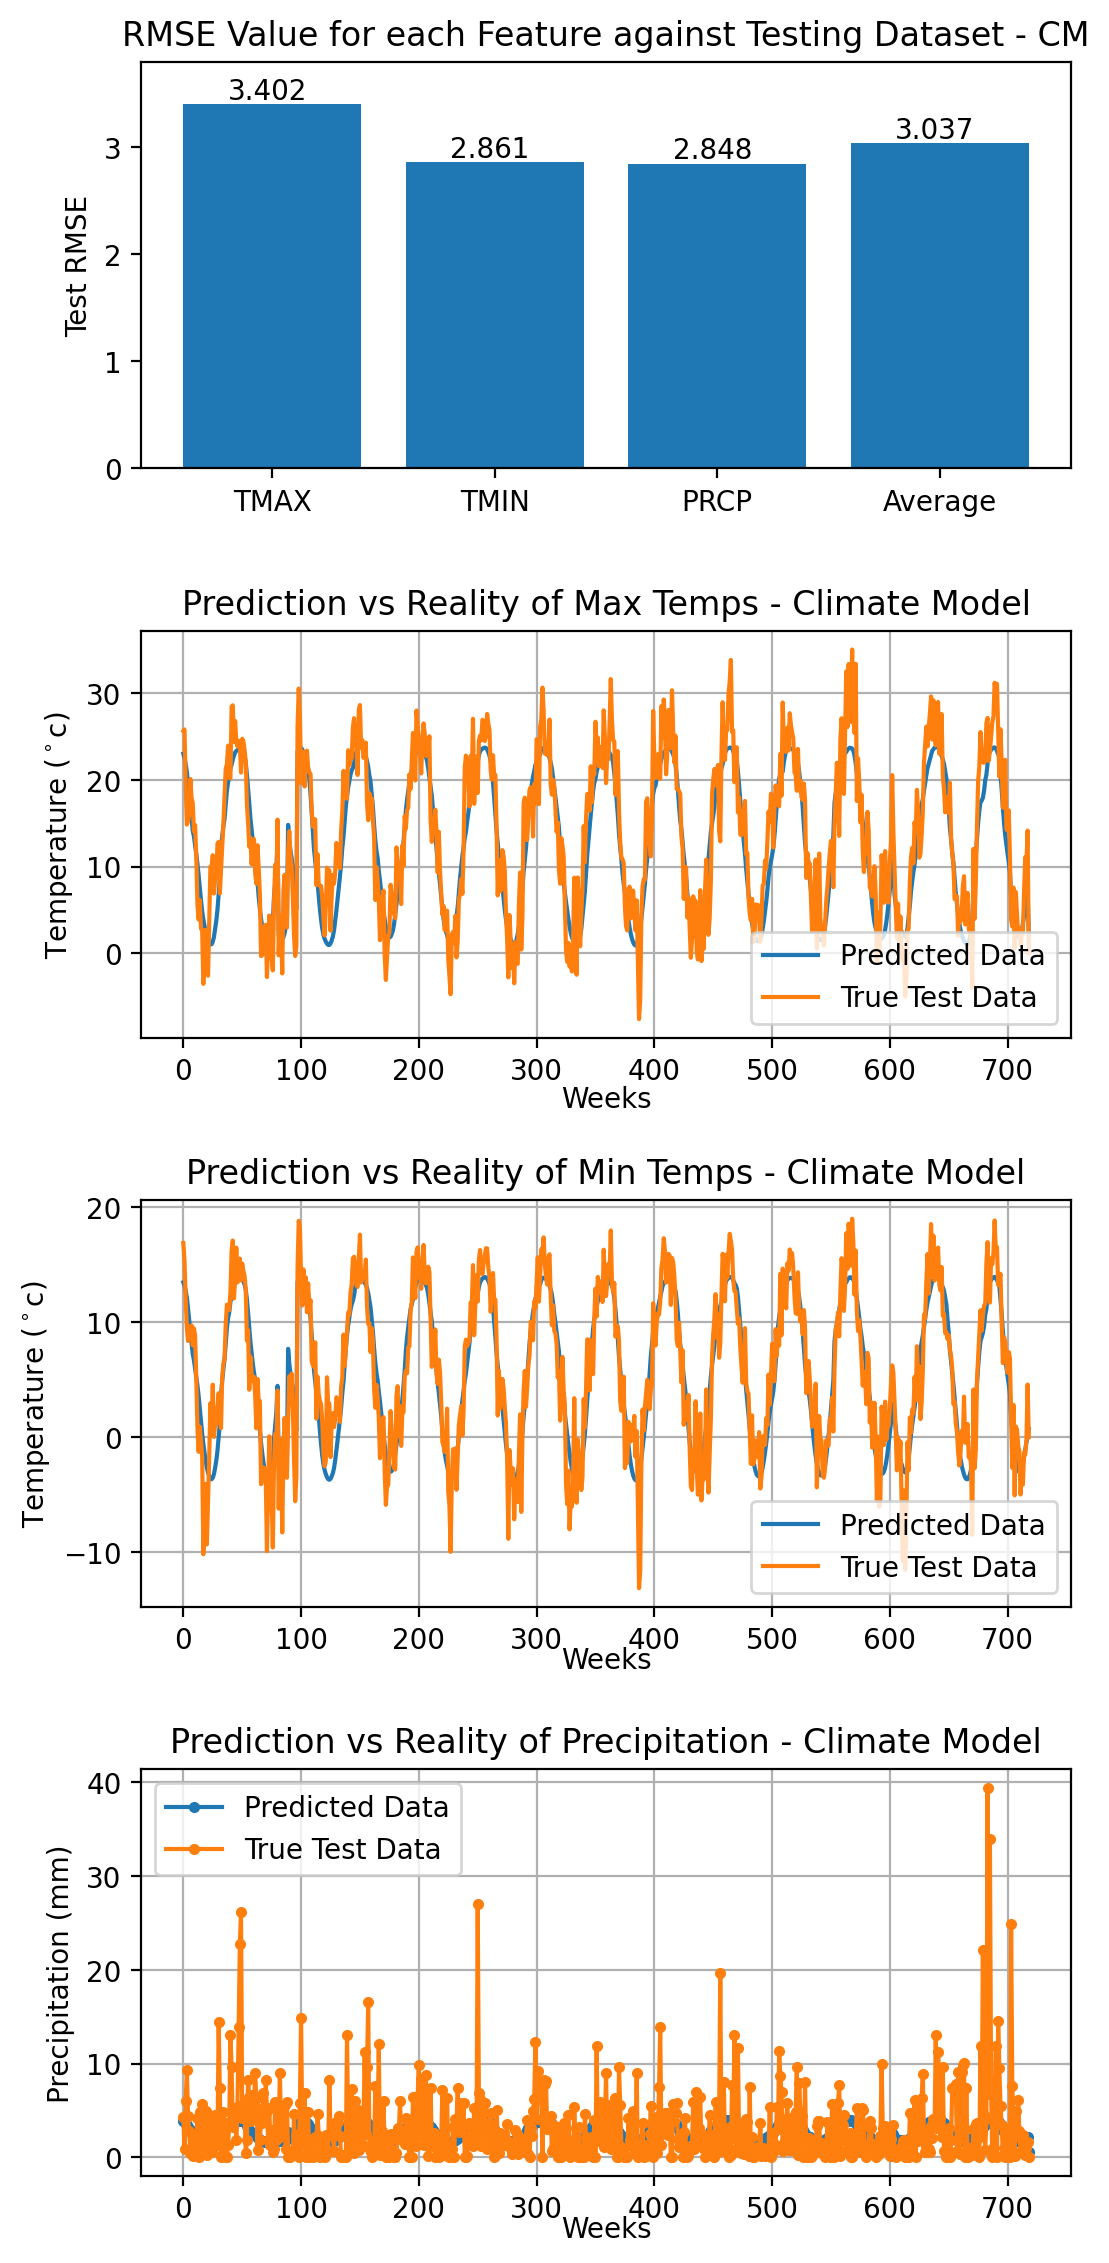

In [621]:
##plotting useful graphs##

#bar chart of RMSE's
fig,ax=plt.subplots(4, figsize=(6,14))
plt.subplots_adjust(hspace=0.4)
ax[0].bar(labels_weekly,rmsd_vals)
ax[0].set_ylabel('Test RMSE')
ax[0].set_title("RMSE Value for each Feature against Testing Dataset - CM")
ax[0].set_ylim(0,3.8)

#labelling top of bars
for i, bar_val in enumerate(rmsd_vals):
    ax[0].text(i-0.2, bar_val+0.05, str(np.round(bar_val,decimals=3)))

#max temps
ax[1].plot(vals_predict_consec[:,0],label="Predicted Data")
ax[1].plot(valsw_opt[7][:,0],label="True Test Data")
ax[1].set_title("Prediction vs Reality of Max Temps - Climate Model")
ax[1].set_xlabel("Weeks",labelpad=0)
ax[1].set_ylabel("Temperature ($^\circ$c)")
ax[1].grid()
ax[1].legend(loc='lower right')

#min temps
ax[2].plot(vals_predict_consec[:,1],label="Predicted Data")
ax[2].plot(valsw_opt[7][:,1],label="True Test Data")
ax[2].set_title("Prediction vs Reality of Min Temps - Climate Model")
ax[2].set_xlabel("Weeks",labelpad=-3)
ax[2].set_ylabel("Temperature ($^\circ$c)")
ax[2].grid()
ax[2].legend()

#precipitation measurements
ax[3].plot(vals_predict_consec[:,2],label="Predicted Data", marker='o', markersize=3)
ax[3].plot(valsw_opt[7][:,2],label="True Test Data", marker='o', markersize=3)
ax[3].set_title("Prediction vs Reality of Precipitation - Climate Model")
ax[3].set_xlabel("Weeks",labelpad=-3)
ax[3].set_ylabel("Precipitation (mm)")
ax[3].grid()
ax[3].legend()

## Question 2 - Weather Model

### Predicting the next day's weather better than assuming the same weather as the previous day

Has to predict the TMAX, TMIN, PRCP and SNOW better than assuming the same weather the next day.

Creating functions to get the datasets into the right format.

In [290]:
def getNNData_daily(var_names,whichStat,windowsize,offset,ratio_test,decrease_train = True):
    """Takes specification of data required and outputs datasets which may train a neural network. 
    
    Inputs
    var_names: list of variable names
    whicStat: station number 0-999
    windowsize: size of LSTM window
    offset: offset of target labels
    ratio_test: ratio of test data to whole dataset
    decrease_train: choose to decrease the size of training set for faster model training
    
    Returns
    vals: dictionary containing Data and Target label arrays for daily values"""
    
    #getting raw measurement from station dictionary
    var, days = getVars(var_names,whichStat)
    
    #checks for not enough data
    if var[len(var_names)-1].shape[0] < 0.01*var[0].shape[0]:
        print(f'Station {whichStat} Missing large amounts of data for final feature.')
        return 0

    #reformatting data into one array with holes where no measurements were taken
    vals_daily = reformat_datafiles(var_names,days,var)

    #reshaping array so is acceptble to function
    if len(var_names) == 1:
        vals_daily = np.reshape(vals_daily,(vals_daily.shape[0],1))
    
    #creating windows
    valsInput = shapeArray2d(vals_daily,windowsize,offset)

    #cleaning data from Nan Values
    valsTrain_clean, valsLabel_clean = clean_sort(valsInput)
    
    #if statements for functions with too many holes in data
    if valsTrain_clean.shape[0] < 0.01*valsInput.shape[1]:
        print(f"Station {whichStat}'s data cannot be cleaned due to high frequency of holes in data.")
        return 0

    #seprating data into groups
    vals = separate_data(valsTrain_clean, valsLabel_clean,ratio_test)
    
    #decreasing size of training set to 3500 windows
    if decrease_train == True:
        for i in range(2):
            vals[i] = vals[i][:10000]
    
    return vals

Use a model structure that has been optimized through trial and error.

In [185]:
def daily_model(vals,windowsize,var_names):
    """This creates, compiles and trains a model on a dataset of average weekly values of climate values and
    gives the resulting relevant accuracy values as well as the trained model.
    Inputs
    vals: dictionary of datasets
    windowsize: windowsize of the training data
    var_names: list of the names of the features
    Returns
    history: stored values specified as the model is trained
    model: keras model trained on inputted data"""
    
    n_features = len(var_names)
    
    #creating model structure
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(40,input_shape=(windowsize,n_features),return_sequences=True))
    model.add(keras.layers.LSTM(20,activation='relu',return_sequences=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(n_features,activation="linear"))
    model.compile(loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
    
    #fitting the model to the data
    history=model.fit(vals[0],vals[1],epochs=6,verbose=0,batch_size=32,
                  validation_data=(vals[2],vals[3])) # callbacks=[TqdmCallback(verbose=0)])
    
    return history, model

#### Running the Model to test against RMSE

In [227]:
#setting and storing values
var_names = ['TMAX', 'TMIN', 'PRCP']
whichStat = 105
windowsized = 20
doffset = 1
ratio = 0.1

#getting datasets to run initial model
vals_b = getNNData_daily(var_names,whichStat,windowsized,doffset,ratio) #creating model
historyd, modeld = daily_model(vals_b,windowsized,var_names) #training model

The RMSE is: 4.2098


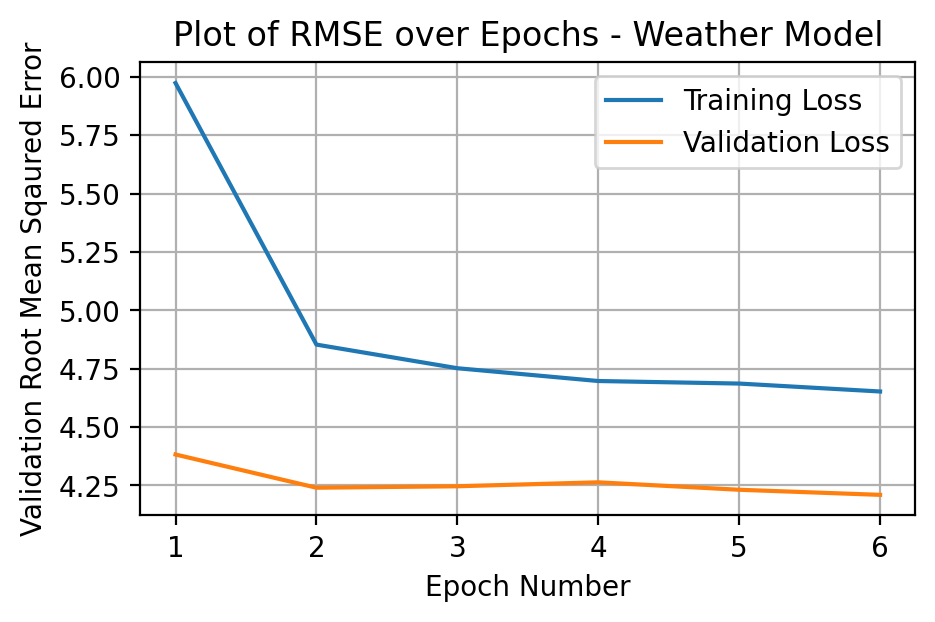

In [515]:
#plotting results over the epochs
fig,ax=plt.subplots(figsize=(5,3))
x = np.arange(0,len(historyd.history['root_mean_squared_error']))+1
ax.plot(x, historyd.history['root_mean_squared_error'],label='Training Loss')
ax.plot(x, historyd.history['val_root_mean_squared_error'],label='Validation Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Validation Root Mean Sqaured Error')
ax.set_title('Plot of RMSE over Epochs - Weather Model')
ax.legend()
ax.grid()

print('The RMSE is:',np.round(historyd.history['val_root_mean_squared_error'][-1],decimals=4))

#setting efficient epochs num value
epochsd = 6

#### Exploring Effects on RMSE of training on different numbers of weather features

In [616]:
var_names_change = [['TMAX'],['TMIN'],['PRCP']]
windowsized = 20
doffset= 1

num_avgs = 10 #number of trainings to avg over
RMSE_featuresd = np.zeros((len(var_names_change),num_avgs))
RMSE_predictd = np.zeros((num_avgs,len(var_names)))

#loop to find avg of RMSE
for i in range(len(var_names_change)):
    for j in range(num_avgs):
        vals = getNNData_daily(var_names_change[i],whichStat,windowsized,doffset,ratio) #formatting data
        history, model = daily_model(vals,windowsized,var_names_change[i]) #creating and training model
        RMSE_featuresd[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
#averaging over predictions
for i in range(num_avgs):
        vals_all = getNNData_daily(var_names,whichStat,windowsized,doffset,ratio) #formatting data
        history, model = daily_model(vals_all,windowsized,var_names) #creating and training model
        vals_predictd = model.predict(vals_all[4],batch_size = 32) 
        RMSE_predictd[i,:] = RMSD(vals_predictd,vals_all[5])
        
RMSE_features_avgd = np.average(RMSE_featuresd,axis=1)
RMSE_predict_avdg = np.average(RMSE_predictd,axis=0)

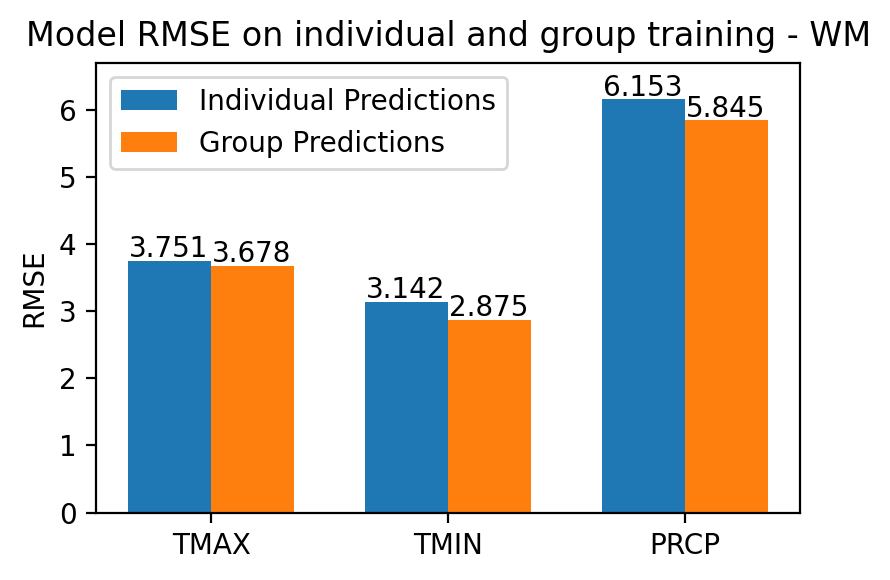

In [620]:
#plotting results
x = np.arange(len(var_names))  # the label locations
width = 0.35  # the width of the bars

#plotting bars
fig, ax = plt.subplots(figsize=(4.2,3))
rect1 = ax.bar(x - width/2, RMSE_features_avgd, width, label='Individual Predictions')
rect2 = ax.bar(x + width/2, RMSE_predict_avgd, width, label='Group Predictions')

#labelling top of bars
for i, x_val in enumerate(x):
    ax.text((x_val - width/2-0.17), RMSE_features_avgd[i]+0.05, str(np.round(RMSE_features_avgd[i],decimals=3)))
    ax.text((x_val + width/2-0.17), RMSE_predict_avgd[i]+0.05, str(np.round(RMSE_predict_avgd[i],decimals=3)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('Model RMSE on individual and group training - WM')
ax.set_xticks(x)
ax.set_xticklabels(var_names)
ax.set_ylim(0,6.7)
ax.legend()
fig.tight_layout()

#### Exploring the effect on RMSE of varying Dataset size for the network to train on

Varying the size of the dataset on which the network is trained to see whether it is possible to train the network on less data and decrease computational cost and memory requirements.

In [186]:
amount_of_data = np.array([0.05,0.1,0.2,0.4,0.7,1]) #variations in windowsize
num_avgs = 10 #number of trainings to avg over
RMSE_amountd = np.zeros((len(amount_of_data),num_avgs))

#loop to find avg of RMSE
for i in range(len(amount_of_data)):
    vals = getNNData_daily(var_names,whichStat,windowsized,doffset,ratio,decrease_train = False) #formatting data
    
    for num in range(2): #changing length of training datasets
        vals[num] = vals[num][:int(amount_of_data[i]*len(vals[num]))]
        
    for j in range(num_avgs): #average this variation
        history, model = daily_model(vals,windowsized,var_names) #creating and training model
        RMSE_amountd[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val

RMSE_amountd_avg = np.average(RMSE_amountd,axis=1)
sd_amountd = np.sqrt(np.var(RMSE_amountd,axis=1))

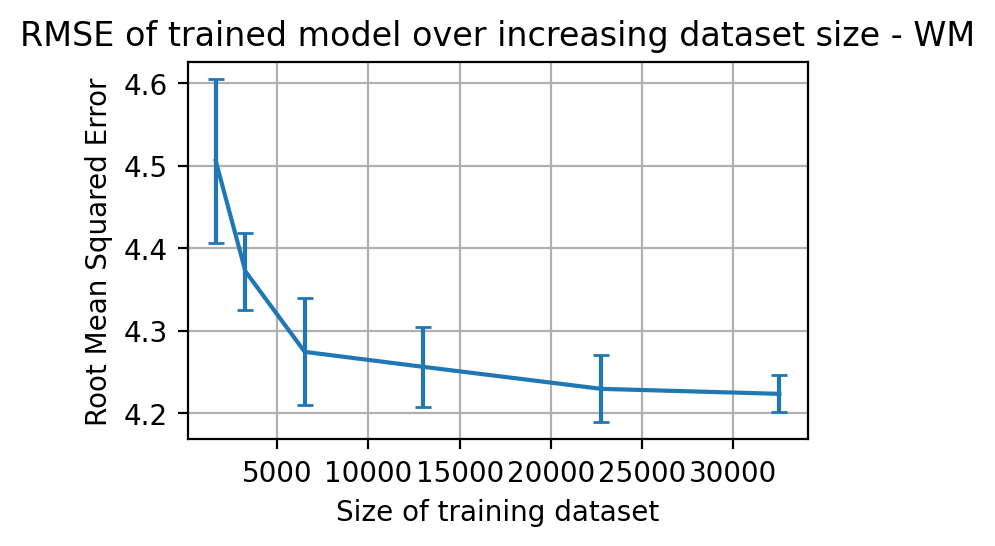

In [668]:
#plotting results
vals = getNNData_daily(var_names,whichStat,windowsized,doffset,ratio,decrease_train = False) 
plt.subplots(figsize=(4,2.5))
plt.errorbar(np.round(amount_of_data*len(vals[0])),RMSE_amountd_avg,yerr=sd_amountd, capsize=3)
plt.title('RMSE of trained model over increasing dataset size - WM')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Size of training dataset')
plt.grid()

In [225]:
improvementd = np.round(((RMSE_amountd_avg[-4]-RMSE_amountd_avg[-2])/RMSE_amountd_avg[-4])*100,decimals=3)
dataincreased = np.round((23000/7000)*100-100,decimals=3)
print('There is a',improvementd,'% improvement in performance of the model for a',dataincreased,'% increase in the amount of data.')


There is a 1.049 % improvement in performance of the model for a 228.571 % increase in the amount of data.


From the data found above the daily data function will be updated to automatically give up to 10,000 data points to train functions on.

#### Windowsize

Plotting average RMSE over windowsize to find an optimum value.

In [608]:
dwindowsize_var = np.array([5,10,15,20,30,40,50,60,70]) #varying windowsize
num_avgs = 10 #number of trainings to avg over
RMSE_windowsd = np.zeros((len(dwindowsize_var),num_avgs))

#loop to find avg of RMSE
for i in range(len(dwindowsize_var)):
    vals = getNNData_daily(var_names,whichStat,dwindowsize_var[i],doffset,ratio) #formatting data
    
    for j in range(num_avgs):
        history, model = daily_model(vals,dwindowsize_var[i],var_names) #creating and training model
        RMSE_windowsd[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
RMSE_windows_avgd = np.average(RMSE_windowsd,axis=1) #results
sd_windowsd = np.sqrt(np.var(RMSE_windowsd,axis=1))

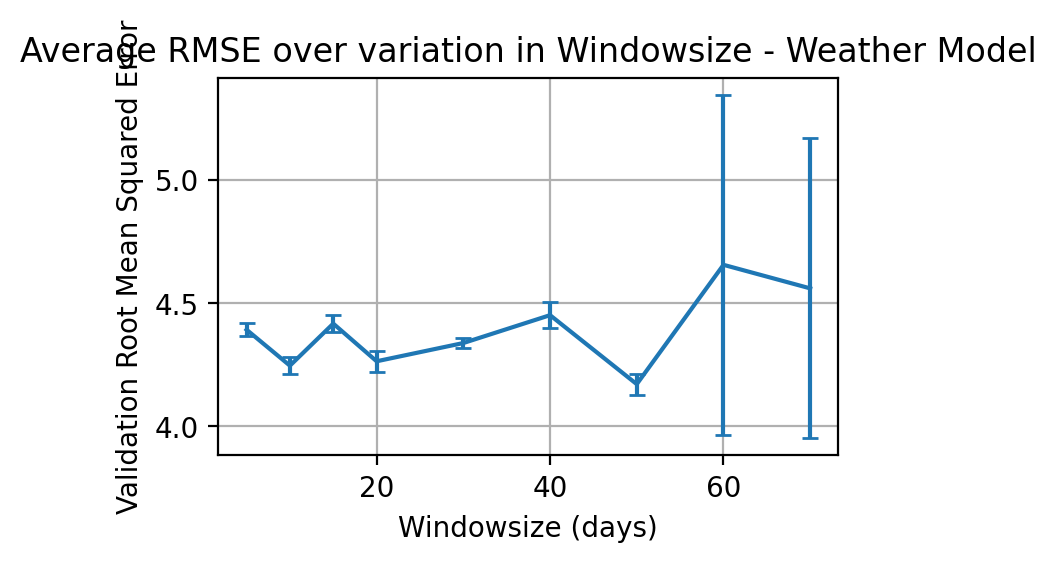

In [609]:
sd_windowsd = np.sqrt(np.var(RMSE_windowsd,axis=1))
#plotting rmse over windowsize
fig, ax = plt.subplots(figsize=(4,2.5))
ax.errorbar(dwindowsize_var,RMSE_windows_avgd,yerr=sd_windowsd,capsize =3)
ax.set_ylabel('val RMSE')
ax.set_xlabel('Windowsize (days)')
ax.set_title('Average RMSE over variation in Windowsize - Weather Model')
ax.grid()

#setting optimum windowsize
windowsized_opt = 50

In [661]:
dwindowsize_var = np.array([45,46,47,48,49,50,51,52,53,54,55]) #varying windowsize
num_avgs = 10 #number of trainings to avg over
RMSE_windowsd = np.zeros((len(dwindowsize_var),num_avgs))

#loop to find avg of RMSE
for i in range(len(dwindowsize_var)):
    vals = getNNData_daily(var_names,whichStat,dwindowsize_var[i],doffset,ratio) #formatting data
    
    for j in range(num_avgs):
        history, model = daily_model(vals,dwindowsize_var[i],var_names) #creating and training model
        RMSE_windowsd[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
RMSE_windows_avgd = np.average(RMSE_windowsd,axis=1) #results
sd_windowsd = np.sqrt(np.var(RMSE_windowsd,axis=1))

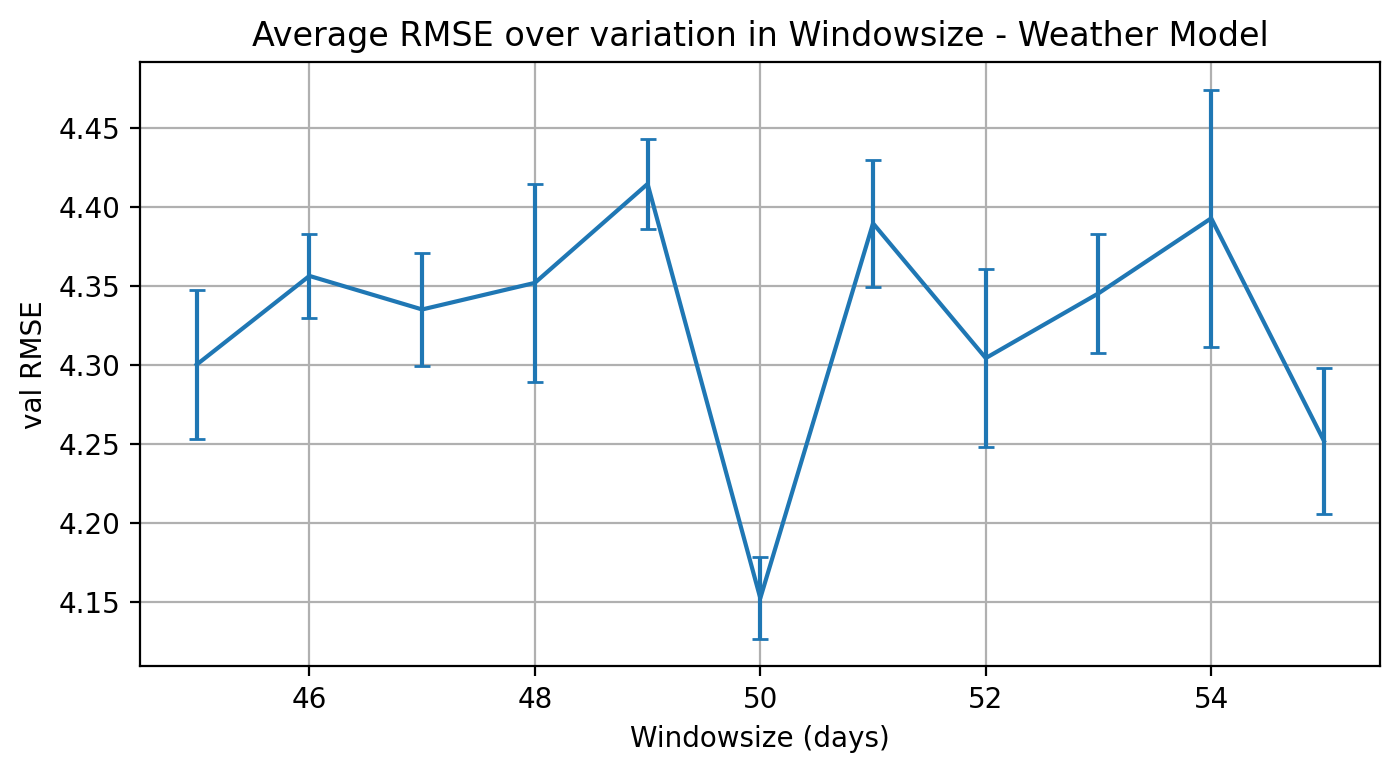

In [662]:
sd_windowsd = np.sqrt(np.var(RMSE_windowsd,axis=1))
#plotting rmse over windowsize
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(dwindowsize_var,RMSE_windows_avgd,yerr=sd_windowsd,capsize =3)
ax.set_ylabel('val RMSE')
ax.set_xlabel('Windowsize (days)')
ax.set_title('Average RMSE over variation in Windowsize - Weather Model')
ax.grid()

### Keras Tuner

Running the same hyperparameter variation code as above to optimize the neural network on this new dataset, using the same method as used for the first question. The windowsize for the values was already set to 20 so this does not need to be updated.

In [247]:
valsd = getNNData_daily(var_names,whichStat,windowsized_opt,doffset,ratio) #creating model

In [248]:
def build_model_daily(hp):
    """Building the Keras tuner model"""
    
    model = keras.models.Sequential()
    
    #adding lstm layers
    model.add(keras.layers.LSTM(hp.Int('lstm_0_unit',min_value=10,max_value=100,step=10),return_sequences=True, input_shape=(valsd[0].shape[1],valsd[0].shape[2])))
    for i in range(hp.Int('n_lstm_layers', 0, 2)):
        model.add(keras.layers.LSTM(hp.Int(f'lstm_{i+1}_units',min_value=10,max_value=70,step=10),return_sequences=True))
    model.add(keras.layers.LSTM(hp.Int('lstm_final_units',min_value=10,max_value=70,step=10)))
    model.add(keras.layers.Dropout(hp.Float('dropout_rate1',min_value=0.1,max_value=0.5,step=0.1)))
    
    #dense layer
    for i in range(hp.Int('n_dense_layers', 0, 2)):
        model.add(keras.layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=10, max_value=50, step=10),activation=hp.Choice(f'dense_activation{i}',values=['relu', 'sigmoid','linear'],default='relu')))
        
    #dropout layer
    model.add(keras.layers.Dropout(hp.Float('dropout_rate2',min_value=0,max_value=0.5,step=0.1)))
    
    #output layer
    model.add(keras.layers.Dense(valsd[1].shape[1], activation=hp.Choice('dense_activation_final',values=['relu', 'sigmoid','linear'],default='linear')))
    model.compile(loss='mse', optimizer='adam',metrics = [tf.keras.metrics.RootMeanSquaredError()])
    return model

In [249]:
#creating tuner object
tuner_daily = kt.Hyperband(build_model_daily,
                     objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=15,
                     factor=3,
                     hyperband_iterations=8,
                     directory='hypertune_dir',
                     project_name='daily_model',
                     overwrite = True)

#routine to stop training if val rmse does not improve after 3 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)

#showing the structure of the hyperparameters
tuner_daily.search_space_summary()

Search space summary
Default search space size: 7
lstm_0_unit (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
n_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lstm_final_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 70, 'step': 10, 'sampling': None}
dropout_rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
n_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation_final (Choice)
{'default': 'linear', 'conditions': [], 'values': ['relu', 'sigmoid', 'linear'], 'ordered': False}


In [250]:
#running the tuner
tuner_daily.search(valsd[0], valsd[1], epochs=10,validation_data=(valsd[2],valsd[3]), callbacks=[stop_early])

Trial 240 Complete [00h 05m 28s]
val_root_mean_squared_error: 10.218575477600098

Best val_root_mean_squared_error So Far: 4.087662696838379
Total elapsed time: 09h 05m 55s
INFO:tensorflow:Oracle triggered exit


In [251]:
#getting best hyperparamter results
best_hps_daily=tuner_daily.get_best_hyperparameters(num_trials=1)[0]

tuner_daily.results_summary(num_trials=1) #outputting structure

#saving model structure
model_daily_opt = tuner_daily.hypermodel.build(best_hps_daily)

Results summary
Results in hypertune_dir\daily_model
Showing 1 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
lstm_0_unit: 30
n_lstm_layers: 0
lstm_final_units: 40
dropout_rate1: 0.30000000000000004
n_dense_layers: 1
dropout_rate2: 0.0
dense_activation_final: linear
lstm_1_units: 10
lstm_2_units: 60
dense_0_units: 50
dense_activation0: sigmoid
dense_1_units: 30
dense_activation1: relu
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 67536def9d8f7d48321c2f9b19bf4caa
Score: 4.087662696838379


In [327]:
model_daily_opt.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 50, 30)            4080      
_________________________________________________________________
lstm_184 (LSTM)              (None, 40)                11360     
_________________________________________________________________
dropout_143 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 50)                2050      
_________________________________________________________________
dropout_144 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 3)                 153       
Total params: 17,643
Trainable params: 17,643
Non-trainable params: 0
_________________________________________________

#### Batchsize

Finding the average RMSE over a varying batchsize to optimise the model.

In [254]:
#varying parameter
batch_sized_var = np.array([16,32,64,128,256])

num_avgs = 10 #number of trainings to avg over
RMSE_batchesd = np.zeros((len(batch_sized_var),num_avgs))

#getting datasets for running average test
vals4 = getNNData_daily(var_names,whichStat,windowsized_opt,doffset,ratio)

#loop to find avg of RMSE
for i in range(len(batch_sized_var)):
    for j in range(num_avgs):
        model_daily_opt = tuner_daily.hypermodel.build(best_hps_daily)
        history=model_daily_opt.fit(vals4[0],vals4[1],epochs=epochsd,verbose=0,batch_size=batch_sized_var[i],
                            validation_data=(vals4[2],vals4[3]))
        RMSE_batchesd[i,j] = history.history['val_root_mean_squared_error'][-1] #storing RMSE val
        
RMSE_batchesd_avg = np.average(RMSE_batchesd,axis=1)
sd_batchesd = np.sqrt(np.var(RMSE_batchesd,axis=1))

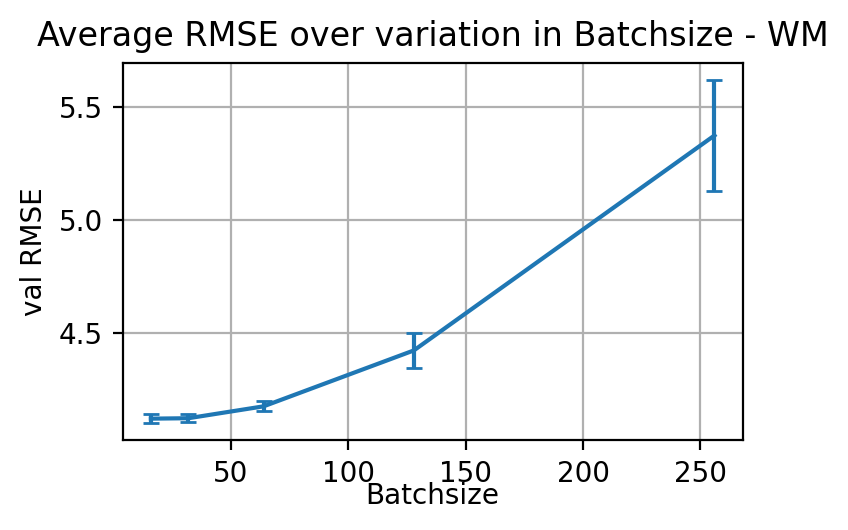

In [541]:
sd_batchesd = np.sqrt(np.var(RMSE_batchesd,axis=1))
#plotting average RMSE over varying batchsize
fig, ax = plt.subplots(figsize=(4,2.5))
ax.errorbar(batch_sized_var,RMSE_batchesd_avg,yerr=sd_batchesd,capsize =3)
ax.set_ylabel('val RMSE')
ax.set_xlabel('Batchsize', labelpad=-2)
ax.set_title('Average RMSE over variation in Batchsize - WM')
ax.grid()

#saving optimum batchsize
batch_sized_opt = 32

#### Plotting RMSE over Epochs on the optimised model

In [314]:
#creating model
valsd_opt = getNNData_daily(var_names,whichStat,windowsized_opt,doffset,ratio)
#training model
model_daily_opt = tuner_daily.hypermodel.build(best_hps_daily)
historyd_opt=model_daily_opt.fit(valsd_opt[0],valsd_opt[1],epochs=epochsd,verbose=0,batch_size=batch_sized_opt,
                            validation_data=(valsd_opt[2],valsd_opt[3]),callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

The RMSE is: 4.1482


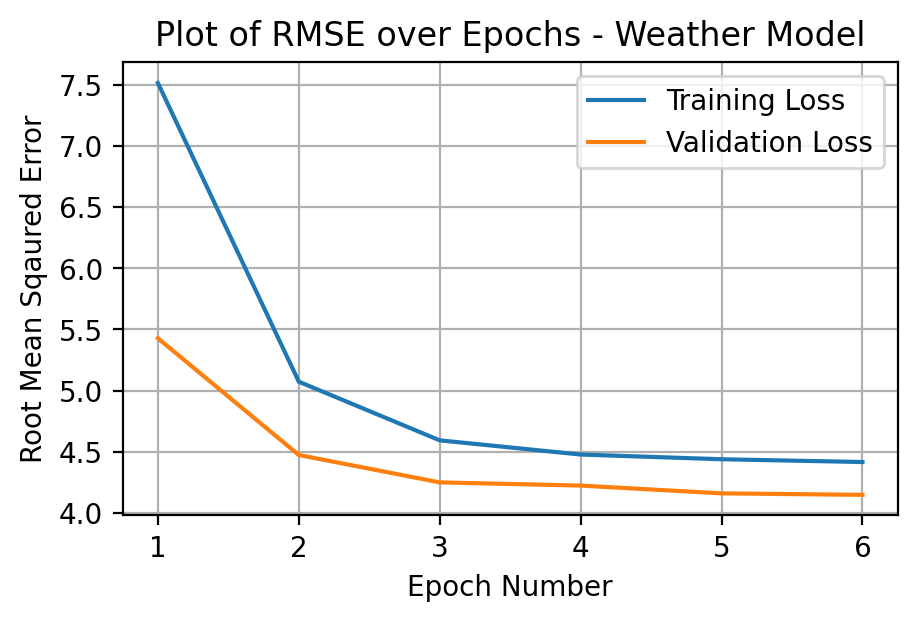

In [542]:
#plotting results over the epochs
fig,ax=plt.subplots(figsize=(5,3))
x = np.arange(0,len(historyd_opt.history['root_mean_squared_error']))+1
ax.plot(x, historyd_opt.history['root_mean_squared_error'],label='Training Loss')
ax.plot(x, historyd_opt.history['val_root_mean_squared_error'],label='Validation Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Root Mean Sqaured Error')
ax.set_title('Plot of RMSE over Epochs - Weather Model')
ax.legend()
ax.grid()

print('The RMSE is:',np.round(historyd_opt.history['val_root_mean_squared_error'][-1],decimals=4)) 
#setting optimum daily epoch size
epochsd_opt = 5

### Plotting Predictions

Plotting the comparison of the model predictions against the predictions of the 'Same-Next-day' method.

In [679]:
#creating model
valsd_opt = getNNData_daily(var_names,whichStat,windowsized_opt,doffset,ratio)

#test against testing set
valsd_predict=model_daily_opt.predict(valsd_opt[4],batch_size = batch_sized_opt)

#getting RMSE's from each method
rmse_nd = RMSD(valsd_opt[4][:,-1,:],valsd_opt[5]) #next day prediction
rmse_NN = RMSD(valsd_predict,valsd_opt[5])    #neural network
print('RMSE of predictions from previous day:', rmse_nd)
print('RMSE of predictions from NN:',rmse_NN)        

RMSE of predictions from previous day: [3.99423853 3.38054836 8.33067647]
RMSE of predictions from NN: [3.61661708 2.83220613 6.27896162]


In [678]:
#creating model
valsd_opt = getNNData_daily(var_names,whichStat,windowsized_opt,doffset,ratio)

history, model = daily_model(valsd_opt,windowsized_opt,var_names)

valsd_predict=model.predict(valsd_opt[4],batch_size = batch_sized_opt)

#test against testing set
#valsd_predict=model_daily_opt.predict(valsd_opt[4],batch_size = batch_sized_opt)

#getting RMSE's from each method
rmse_nd = RMSD(valsd_opt[4][:,-1,:],valsd_opt[5]) #next day prediction
rmse_NN = RMSD(valsd_predict,valsd_opt[5])    #neural network
print('RMSE of predictions from previous day:', rmse_nd)
print('RMSE of predictions from NN:',rmse_NN)

#averaging over predictions
for i in range(num_avgs):
        vals_all = getNNData_daily(var_names,whichStat,windowsized,doffset,ratio) #formatting data
        history, model = daily_model(vals_all,windowsized,var_names) #creating and training model
        vals_predictd = model.predict(vals_all[4],batch_size = 32) 
        RMSE_predictd[i,:] = RMSD(vals_predictd,vals_all[5])
        

RMSE of predictions from previous day: [3.99423853 3.38054836 8.33067647]
RMSE of predictions from NN: [3.50552478 2.79232734 6.26963142]


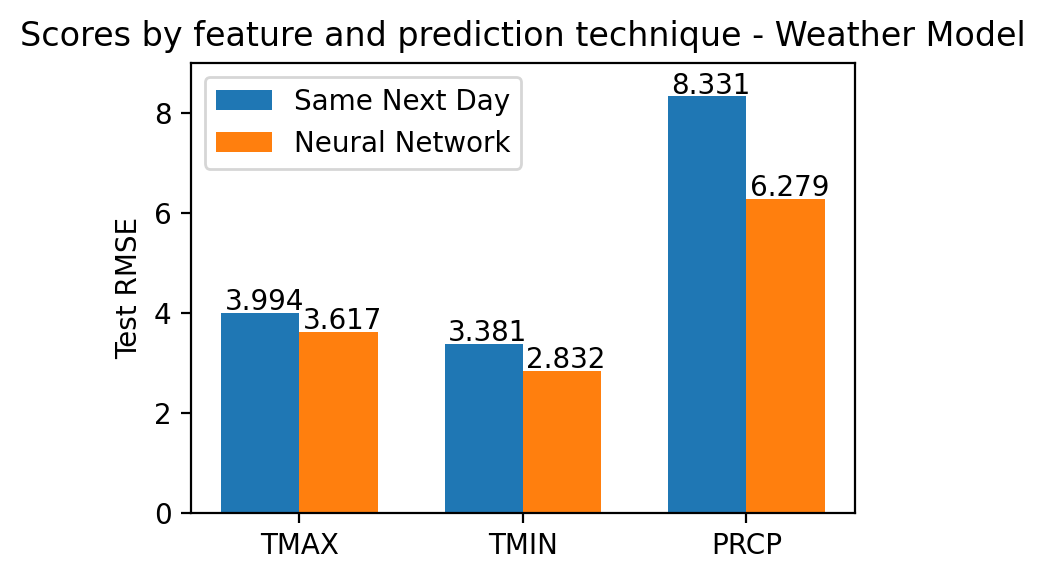

In [677]:
#plotting results

x = np.arange(len(var_names))  # the label locations
width = 0.35  # the width of the bars

#plotting bars
fig, ax = plt.subplots(figsize=(4,3))
rect1 = ax.bar(x - width/2, rmse_nd, width, label='Same Next Day')
rect2 = ax.bar(x + width/2, rmse_NN, width, label='Neural Network')

#labelling top of bars
for i, x_val in enumerate(x):
    ax.text((x_val - width/2-0.16), rmse_nd[i]+0.05, str(np.round(rmse_nd[i],decimals=3)))
    ax.text((x_val + width/2-0.16), rmse_NN[i]+0.05, str(np.round(rmse_NN[i],decimals=3)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test RMSE')
ax.set_title('Scores by feature and prediction technique - Weather Model')
ax.set_ylim(0,9)
ax.set_xticks(x)
ax.set_xticklabels(var_names)
ax.legend()
fig.tight_layout()
plt.show()

## Exploring Further

### How closely related are the weather patterns between stations?

Going to graph how well the model previously trained on station 105 predict the weather in the surrounding stations.

Create a function to access all of the data and store it, then creates functions to format this data to their respective requirements.

In [318]:
def days_samp_data(valsTrain_clean,valsLabel_clean,num_days):
    """This function takes in window and target label data arrays and outputs a set number of random windows and 
    targets of data into a dictionary.
    
    Inputs
    valsTrain_clean: (num_windows,windowsize,num_features)
    valsLabel_clean: (num_windows,num_features)
    num_days: number of windows to take
    
    Returns
    vals: dictionary containing Data and Target label arrays for the num_days last windows:
        data: (num_days,windowsize,num_features)
        label: (num_days,num_features)
    """
    
    #place this data into training, testing and validation data
    num_test = int(ratio*len(valsTrain_clean[:,0,0]))
    
    #creating dictionary
    vals_samp = {}
    
    #using this to take a random sample of windows and targets
    null1, vals_samp[0], null2, vals_samp[1] = train_test_split(valsTrain_clean, valsLabel_clean, test_size=num_days, random_state = 42)
    
    return vals_samp

In [319]:
def get_data_all_stats(var_names):
    """Gets daily feature data for all stations and outputs this into a dictionary which stores arrays of datasets
    for each station."""
    
    all_stats_vals_daily = {}
    
    for whichStat in range(991):
        
        #get data from station
        var, days = getVars(var_names,whichStat)
        
        #passes through 0 value
        if var == 0:
            all_stats_vals_daily[whichStat] = np.array([0,0,0])
            continue
    
        #outputs error if the available data for final feature is less than the sample size required
        if var[len(var_names)-1].shape[0] < 2:
            print(f'Station {whichStat} includes only 1 measurement for final feature.')
            all_stats_vals_daily[whichStat] = 0
            continue
        
        #reformatting data into one array with holes where no measurements were taken
        all_stats_vals_daily[whichStat] = reformat_datafiles(var_names,days,var)
        
    return all_stats_vals_daily

In [320]:
def get_samp_days_arr(all_stats_data,whichStat,windowsize,offset,num_days):
    """Takes specification of data required and outputs datasets which a neural network may predict from.
    Uses input from a dictionary storing all stations data.
    
    Inputs
    all_stats_vals_daily: dictionary of all stations data
    whichStat: station number 0-999
    windowsize: size of LSTM window
    offset: offset of target labels
    ratio_test: ratio of test data to whole dataset
    num_days: number of windows to sample
    
    Returns
    vals: dictionary containing Data and Target label arrays for daily values"""
    
    if np.all(all_stats_data[whichStat] == 0):
        print('Station',whichStat, 'lacks at least one set of feature measurements.',)
        return 0
    
    #outputs error if the available data for final feature is less than the sample size required
    if len(all_stats_data[whichStat][~np.isnan(all_stats_data[whichStat][:,-1]),-1]) < num_days:
        print(f'Station {whichStat} Missing large amounts of data for final feature.')
        return 0
    
    #creating windows
    valsInput = shapeArray2d(all_stats_data[whichStat],windowsize,offset)

    #cleaning data from Nan Values
    valsTrain_clean, valsLabel_clean = clean_sort(valsInput)
    
    #outputs error if the available data is less than the sample size required
    if valsTrain_clean.shape[0] < num_days:
        print(f"Station {whichStat}'s data cannot be cleaned due to high frequency of holes in data.")
        return 0

    #taking the end of the data
    vals_samp = days_samp_data(valsTrain_clean,valsLabel_clean,num_days)
    
    return vals_samp

#### Plotting Stations on a Map
Use a linear projection in longitude and latitude to map the stations across the world.

(991, 3)


Text(0, 0.5, 'Longitude')

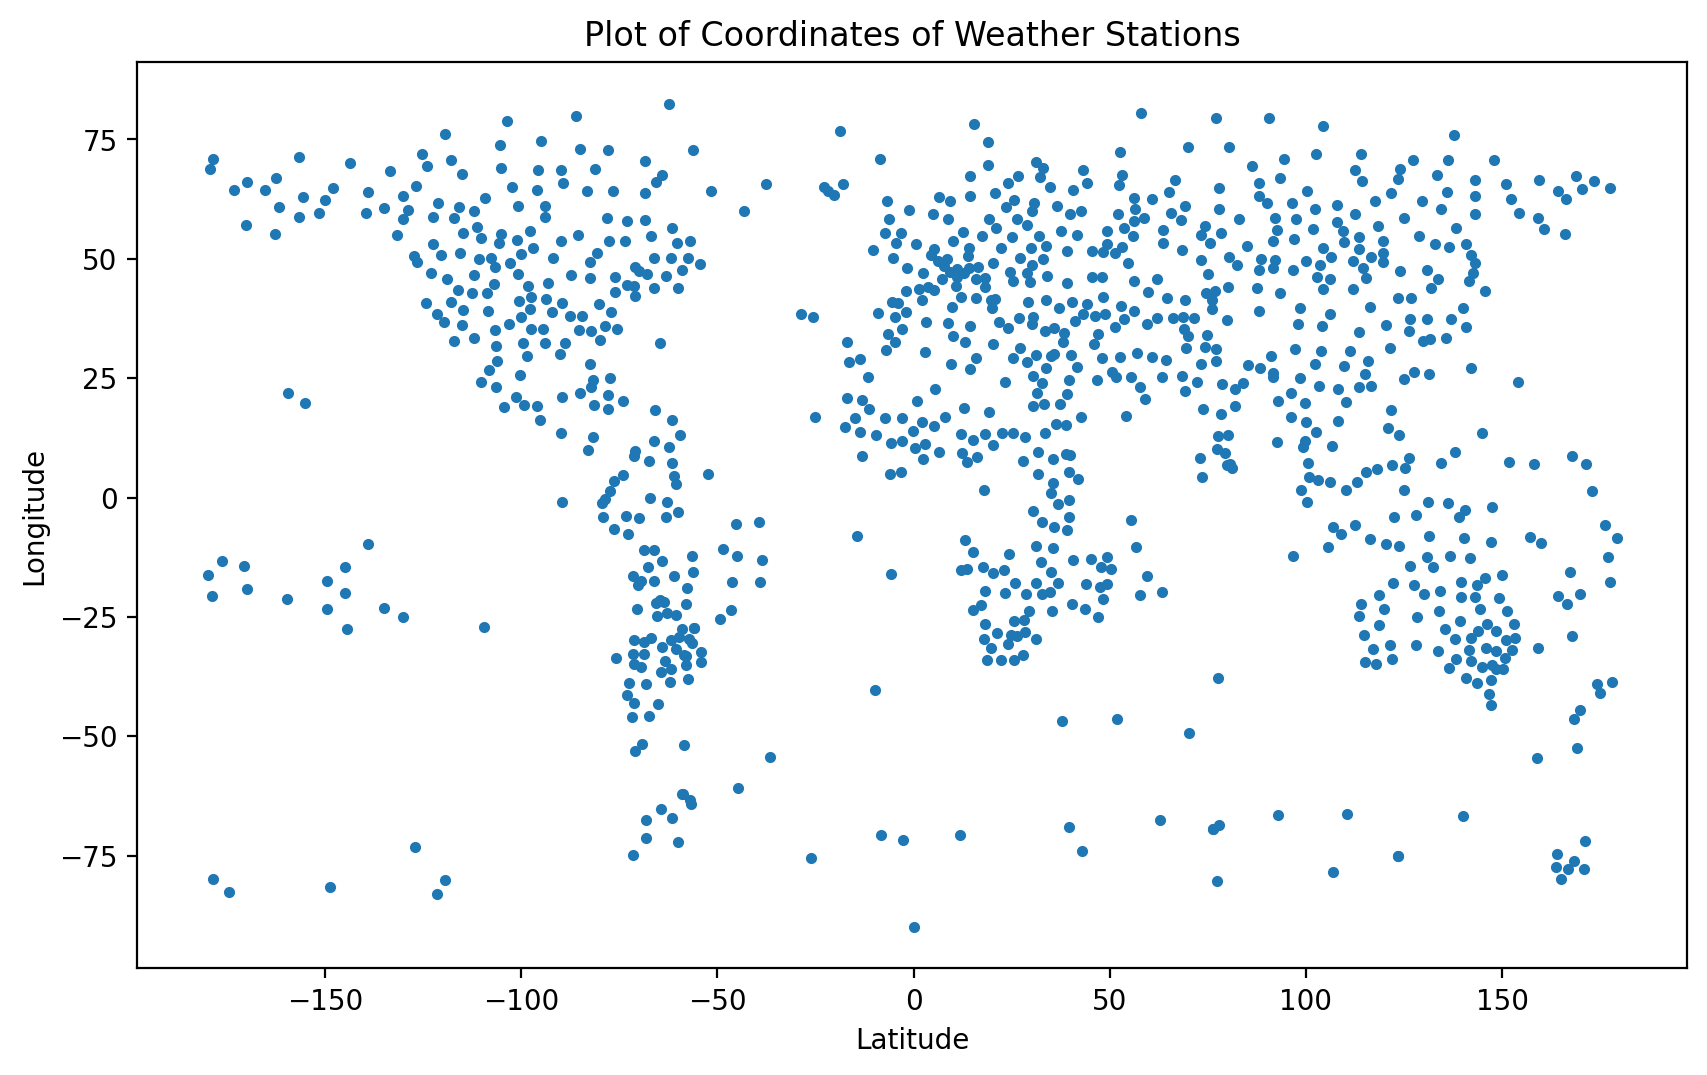

In [321]:
#store the coordinates of the stations
coord_store = ghn.readStationsFileSave()
print(coord_store.shape)

#plotting in simple manner
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(coord_store[:,1], coord_store[:,0],'.')
ax.set_title('Plot of Coordinates of Weather Stations')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

#### Getting RMSE of surrounding Stations

In [322]:
def stat_list_area(whichStat,var):
    """Outputs a list of the stations in the area surrounding a specific station
    Inputs
    whichStat: main station
    var: variation in latitude and longitude surrounding the station
    Outputs
    stat_in: stations in list in surrouding area
    """
    coord_store = ghn.readStationsFileSave()

    #coordinates of main station
    lat_main = coord_store[whichStat,1]
    long_main = coord_store[whichStat,0]

    #creating truth array of values in area
    lat_truth = np.logical_and(((lat_main-var) < coord_store[:,1]), (coord_store[:,1] < (lat_main+var)))
    long_truth = np.logical_and(((long_main-var) < coord_store[:,0]), (coord_store[:,0] < (long_main+var)))
    stat_in = np.where(np.logical_and(lat_truth, long_truth) == 1)[0]

    return stat_in

To do the model predictions we must iterate over each relevant station, and so it does not make the program more efficient to store the stations in arrays.

In [323]:
def get_samp_stat_RMSE_arr(model,all_stats_data,windowsize,num_days,var,main_stat, batch_sized_opt,offset=1,):
    """Gets the RMSE for all of the stations in the specified area.
    Offset is assumed as 1.
    Inputs
    num_days: number of days of samples to take
    stations_in: array of station numbers in the area
    var: variation in latitude/longitude to include stations within
    
    Returns
    rmse_coords: array of feature rmse's and coordinate values"""
    
    
    #getting list of station numbers in area
    stations_in = stat_list_area(main_stat,var)  
    #creating rmse array
    rmse = np.zeros((len(stations_in),len(var_names)))
    
    #taking sample data from all applicable stations
    for i, whichStat in enumerate(stations_in):
        
        #dont predict values for main station
        if whichStat == main_stat:
            continue
        
        #getting dict of station windows and targets
        stat_samp_data = get_samp_days_arr(all_stats_data,whichStat,windowsize,offset,num_days)
        
        #checking if dict is empty
        if stat_samp_data == 0:
            continue
        
        #predicting weather using model
        vals_predicted = model.predict(stat_samp_data[0],batch_size = batch_sized_opt)
        
        #finding rmse between predictions and reality
        rmse[i,:] = RMSD(vals_predicted,stat_samp_data[1])
    
    #placing non zero rmse and coords in same array
    coord_store = ghn.readStationsFileSave()
    
    coords = coord_store[stations_in,:]
    rmse_coords = np.concatenate((rmse,coords),axis=1)
    rmse_coords = np.concatenate((rmse_coords,stations_in[:,None]),axis=1) #adding stations number to array
    rmse_coords_clean = rmse_coords[~np.any(rmse_coords[:,0:3] == 0,axis=1)]
    
    #number of stations lost to errors
    num_lost = len(stations_in) - len(rmse_coords_clean[:,0]) - 1 
    print('Number of stations lost:',num_lost)
        
    return rmse_coords_clean

In [328]:
#load all station data into script
var_names = ['TMAX','TMIN','PRCP']
all_stats_data = get_data_all_stats(var_names)

Station 118 doesnt have PRCP measurements.
Station 119 doesnt have TMAX measurements.
Station 120 doesnt have TMAX measurements.
Station 121 doesnt have TMAX measurements.
Station 122 doesnt have TMAX measurements.
Station 123 doesnt have TMAX measurements.
Station 124 doesnt have TMAX measurements.
Station 125 doesnt have TMAX measurements.
Station 126 doesnt have TMAX measurements.
Station 127 doesnt have TMAX measurements.
Station 132 doesnt have TMAX measurements.
Station 134 doesnt have TMAX measurements.
Station 138 doesnt have TMAX measurements.
Station 140 includes only 1 measurement for final feature.
Station 142 doesnt have TMAX measurements.
Station 143 doesnt have TMAX measurements.
Station 144 doesnt have TMAX measurements.
Station 145 doesnt have TMAX measurements.
Station 146 doesnt have TMAX measurements.
Station 147 doesnt have TMAX measurements.
Station 177 doesnt have TMAX measurements.
Station 193 doesnt have TMAX measurements.
Station 355 doesnt have PRCP measureme

In [329]:
#getting rmse values for stations
num_days = 200 #number of days for weather station to predict weather and find RMSE from
main_stat = 105
var = 30 #variation in latitude and longitude from main station to include stations within

#getting the coordinates and associated rmse of each station within the area
rmse_coords_area = get_samp_stat_RMSE_arr(model_daily_opt,all_stats_data,windowsized_opt,num_days,var,main_stat,
                                          batch_sized_opt,offset=1)

Station 7's data cannot be cleaned due to high frequency of holes in data.
Station 156's data cannot be cleaned due to high frequency of holes in data.
Station 355 lacks at least one set of feature measurements.
Station 357's data cannot be cleaned due to high frequency of holes in data.
Station 411's data cannot be cleaned due to high frequency of holes in data.
Station 465's data cannot be cleaned due to high frequency of holes in data.
Station 466's data cannot be cleaned due to high frequency of holes in data.
Station 467's data cannot be cleaned due to high frequency of holes in data.
Station 468's data cannot be cleaned due to high frequency of holes in data.
Station 469's data cannot be cleaned due to high frequency of holes in data.
Station 488's data cannot be cleaned due to high frequency of holes in data.
Station 489's data cannot be cleaned due to high frequency of holes in data.
Station 522's data cannot be cleaned due to high frequency of holes in data.
Station 523's data

### Plotting the stations with RMSE

Plotting the stations surrounding the original station on a map where the colour of the marker is given by the size of the RMSE, and so how well the model predicts the surrounding stations.

Number of stats in area with TMAX RMSE lower than main station is: 27
Number of stats in area with TMIN RMSE lower than main station is: 3
Number of stats in area with PRCP RMSE lower than main station is: 94
Number of stats in the area where all 3 features RMSE's are less than the main stations: 2


Text(0.5, 1.0, 'avg. RMSE')

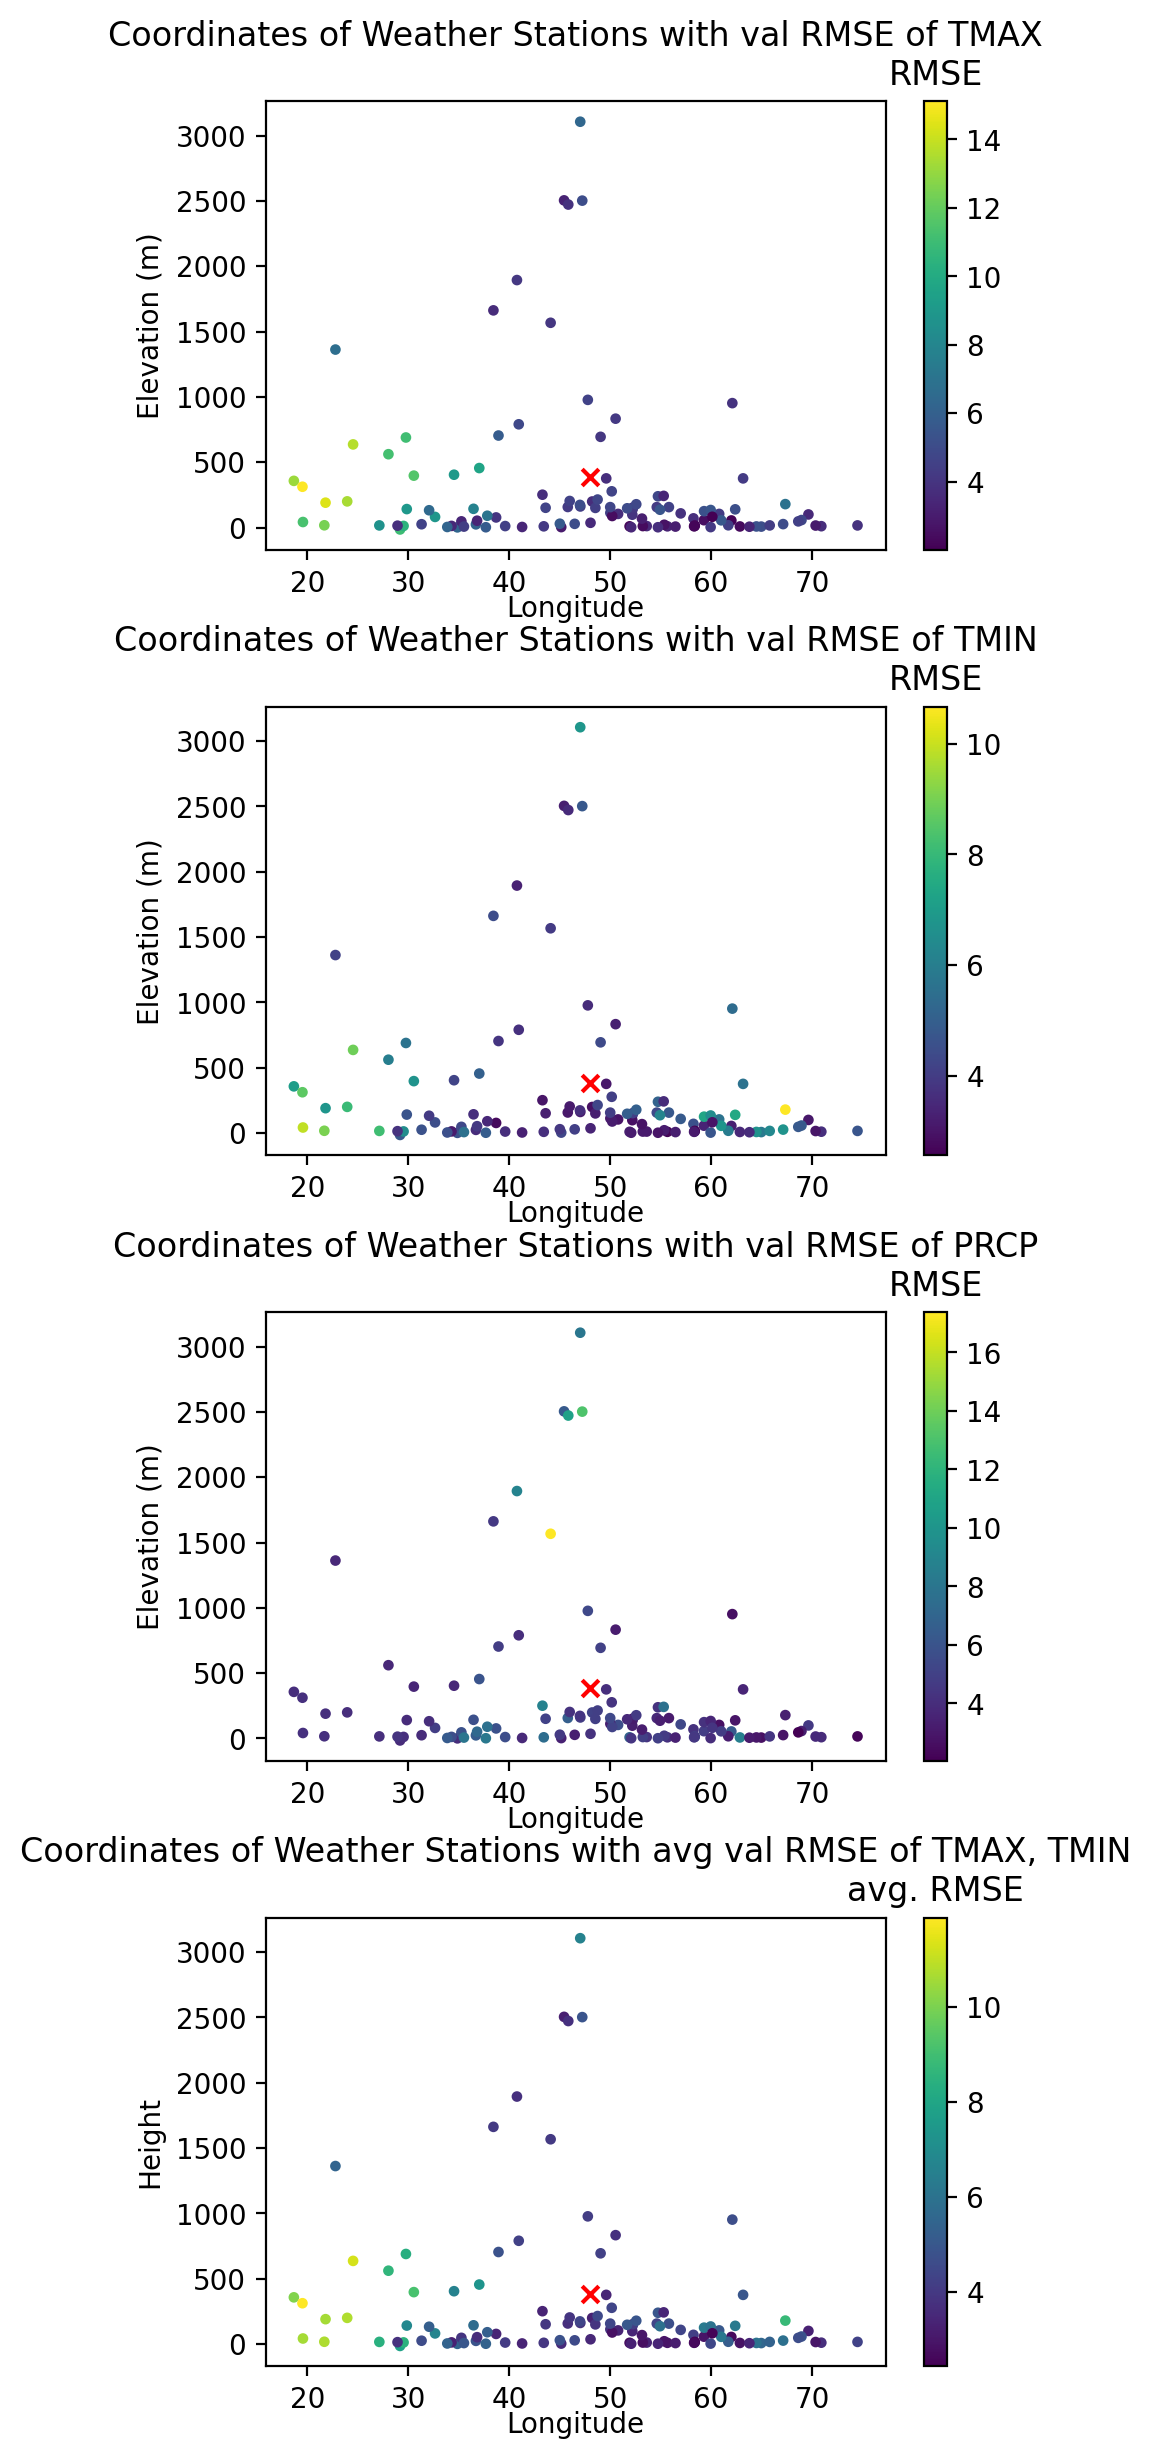

In [583]:
#noting number of stations where prediction RMSE is lower than test RMSE of main stat
for i, name in enumerate(var_names):
    print('Number of stats in area with',name,'RMSE lower than main station is:',
          len(rmse_coords_area[np.where(rmse_coords_area[:,i] < rmse_NN[i]),i][0]))
print("Number of stats in the area where all 3 features RMSE's are less than the main stations:",
      len(rmse_coords_area[np.all(rmse_coords_area[:,0:3] < rmse_NN, axis=1),0]))


main_stat_coords = coord_store[main_stat] #getting main station coordinates
avg_rmse_area = np.average(rmse_coords_area[:,0:2], axis=1) #averaging the rmse over all temp features

#plotting RMSE over height and longitude
fig, ax = plt.subplots(len(var_names)+1,figsize=(5,15))
plt.subplots_adjust(hspace=0.35)
for i in range(len(var_names)):
    rmse_coord_cutvals_area = rmse_coords_area[np.where(rmse_coords_area[:,i] < 50)[0],:] #cleans outliers
    z = ax[i].scatter(rmse_coord_cutvals_area[:,3], rmse_coord_cutvals_area[:,5],c=rmse_coord_cutvals_area[:,i],s=8)
    ax[i].scatter(main_stat_coords[0],main_stat_coords[2],marker='x',c='red')
    ax[i].set_title(f'Coordinates of Weather Stations with val RMSE of {var_names[i]}',pad=20)
    ax[i].set_xlabel('Longitude', labelpad=-1)
    ax[i].set_ylabel('Elevation (m)')
    cbar = fig.colorbar(z, ax=ax[i])
    cbar.ax.set_title("RMSE")

#plotting stations with an avg RMSE value
z = ax[3].scatter(rmse_coords_area[:,3], rmse_coords_area[:,5],c=avg_rmse_area,s=8)
ax[3].scatter(main_stat_coords[0],main_stat_coords[2],marker='x',c='red')
ax[3].set_title('Coordinates of Weather Stations with avg val RMSE of TMAX, TMIN',pad=20)
ax[3].set_xlabel('Longitude', labelpad=-1)
ax[3].set_ylabel('Height')
cbar = fig.colorbar(z, ax=ax[3])
cbar.ax.set_title("avg. RMSE")

Now going to plot over longitude and latitude across the world the TMIN and TMAX RMSE's to see how this varies, as it possible to see that elevation does have a strong effect on the models ability to predict TMAX and TMIN. 

In [331]:
#getting rmse values for stations
var_names = ['TMAX','TMIN', 'PRCP'] #include PRCP as the model requires this input
num_days = 200
main_stat = 105
var = 180 #includes all weather stations

#getting the coordinates and associated rmse of each station within the area
rmse_coords = get_samp_stat_RMSE_arr(model_daily_opt,all_stats_data,windowsized_opt,num_days,var,main_stat, 
                                     batch_sized_opt,offset=1)

Station 0's data cannot be cleaned due to high frequency of holes in data.
Station 1 Missing large amounts of data for final feature.
Station 7's data cannot be cleaned due to high frequency of holes in data.
Station 9's data cannot be cleaned due to high frequency of holes in data.
Station 10's data cannot be cleaned due to high frequency of holes in data.
Station 11's data cannot be cleaned due to high frequency of holes in data.
Station 12's data cannot be cleaned due to high frequency of holes in data.
Station 13's data cannot be cleaned due to high frequency of holes in data.
Station 14's data cannot be cleaned due to high frequency of holes in data.
Station 16's data cannot be cleaned due to high frequency of holes in data.
Station 17's data cannot be cleaned due to high frequency of holes in data.
Station 18's data cannot be cleaned due to high frequency of holes in data.
Station 19's data cannot be cleaned due to high frequency of holes in data.
Station 20's data cannot be clea

Station 267's data cannot be cleaned due to high frequency of holes in data.
Station 280's data cannot be cleaned due to high frequency of holes in data.
Station 281's data cannot be cleaned due to high frequency of holes in data.
Station 282's data cannot be cleaned due to high frequency of holes in data.
Station 283's data cannot be cleaned due to high frequency of holes in data.
Station 284's data cannot be cleaned due to high frequency of holes in data.
Station 285's data cannot be cleaned due to high frequency of holes in data.
Station 286's data cannot be cleaned due to high frequency of holes in data.
Station 297's data cannot be cleaned due to high frequency of holes in data.
Station 319's data cannot be cleaned due to high frequency of holes in data.
Station 320's data cannot be cleaned due to high frequency of holes in data.
Station 321's data cannot be cleaned due to high frequency of holes in data.
Station 322's data cannot be cleaned due to high frequency of holes in data.

Station 489's data cannot be cleaned due to high frequency of holes in data.
Station 490's data cannot be cleaned due to high frequency of holes in data.
Station 491's data cannot be cleaned due to high frequency of holes in data.
Station 492's data cannot be cleaned due to high frequency of holes in data.
Station 493's data cannot be cleaned due to high frequency of holes in data.
Station 494's data cannot be cleaned due to high frequency of holes in data.
Station 495's data cannot be cleaned due to high frequency of holes in data.
Station 498's data cannot be cleaned due to high frequency of holes in data.
Station 499's data cannot be cleaned due to high frequency of holes in data.
Station 503's data cannot be cleaned due to high frequency of holes in data.
Station 522's data cannot be cleaned due to high frequency of holes in data.
Station 523's data cannot be cleaned due to high frequency of holes in data.
Station 524's data cannot be cleaned due to high frequency of holes in data.

Station 865's data cannot be cleaned due to high frequency of holes in data.
Station 867's data cannot be cleaned due to high frequency of holes in data.
Station 868's data cannot be cleaned due to high frequency of holes in data.
Station 869's data cannot be cleaned due to high frequency of holes in data.
Station 870's data cannot be cleaned due to high frequency of holes in data.
Station 875's data cannot be cleaned due to high frequency of holes in data.
Station 876's data cannot be cleaned due to high frequency of holes in data.
Station 877's data cannot be cleaned due to high frequency of holes in data.
Station 879's data cannot be cleaned due to high frequency of holes in data.
Station 890 lacks at least one set of feature measurements.
Station 960's data cannot be cleaned due to high frequency of holes in data.
Station 961's data cannot be cleaned due to high frequency of holes in data.
Station 962's data cannot be cleaned due to high frequency of holes in data.
Station 965's da

Number of stats in area with TMAX RMSE lower than main station is: 59
Number of stats in area with TMIN RMSE lower than main station is: 16
Number of stats in area with PRCP RMSE lower than main station is: 431
Number of stats where all 3 features RMSE's are less than the main stations: 5


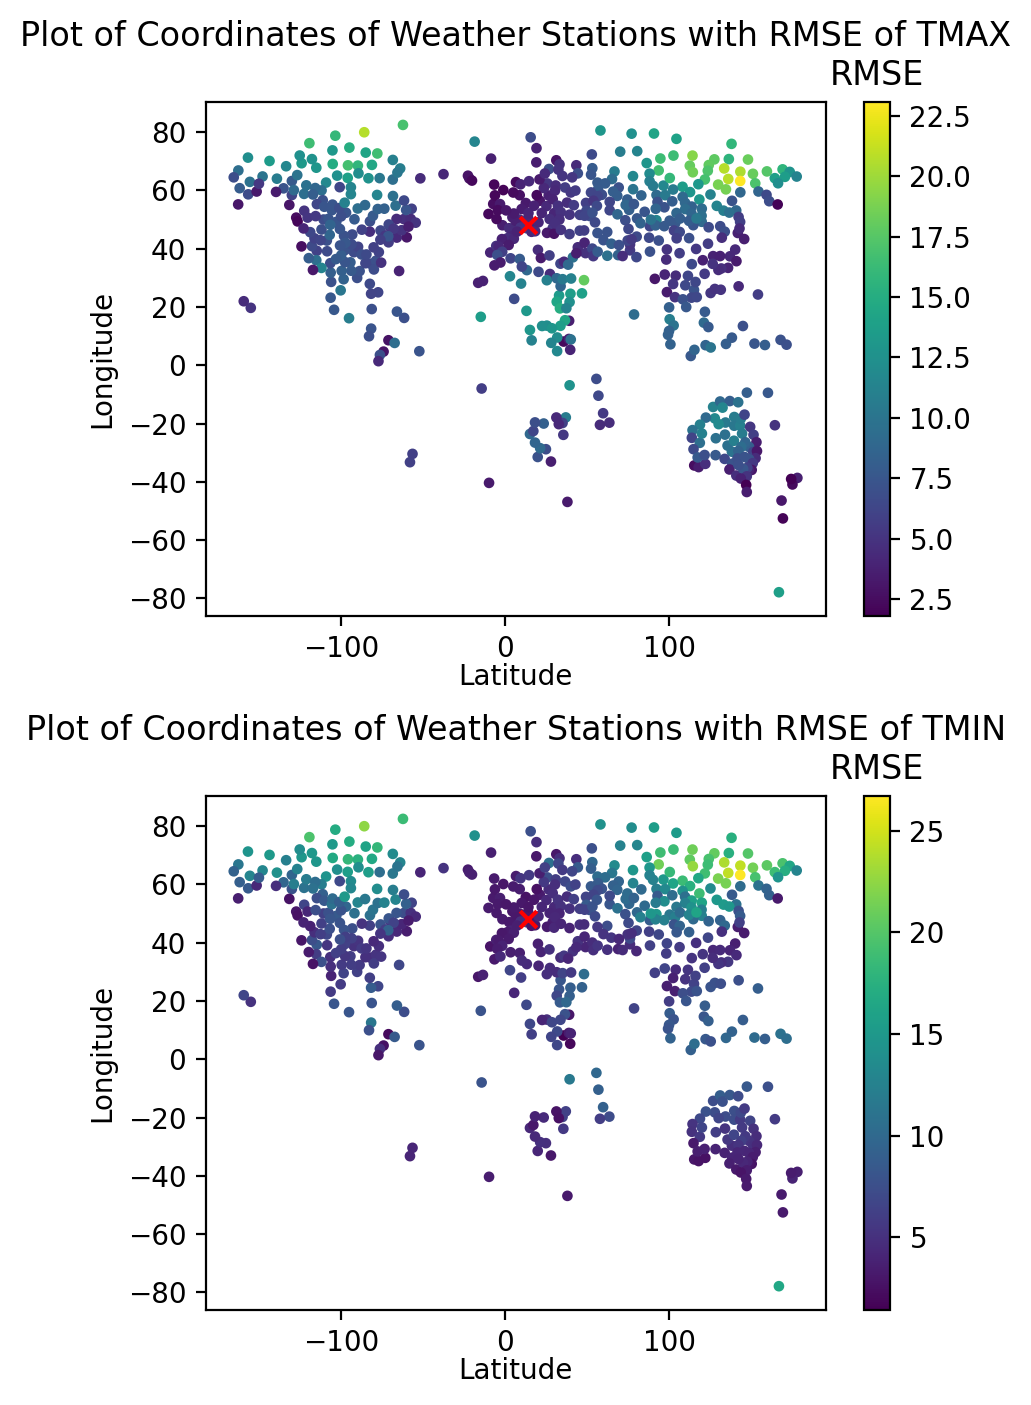

In [588]:
#noting number of stations where prediction RMSE is lower than test RMSE of main stat
for i, name in enumerate(var_names):
    print('Number of stats in area with',name,'RMSE lower than main station is:',
          len(rmse_coords[np.where(rmse_coords[:,i] < rmse_NN[i]),i][0]))
print("Number of stats where all 3 features RMSE's are less than the main stations:",
      len(rmse_coords[np.all(rmse_coords[:,0:3] < rmse_NN, axis=1),0]))

#formatting values
main_stat_coords = coord_store[main_stat]

#averaging the rmse over temp features
avg_rmse = np.average(rmse_coords[:,0:2], axis=1)

#plotting RMSE over latitude and longitude
fig, ax = plt.subplots(2,figsize=(5,8))
plt.subplots_adjust(hspace=0.35)
for i in range(2):
    rmse_coord_cutvals = rmse_coords[np.where(rmse_coords[:,i] < 40)[0],:] #cleans outliers
    z = ax[i].scatter(rmse_coord_cutvals[:,4], rmse_coord_cutvals[:,3],c=rmse_coord_cutvals[:,i],s=8)
    ax[i].scatter(main_stat_coords[1],main_stat_coords[0],marker='x',c='red')
    ax[i].set_title(f'Plot of Coordinates of Weather Stations with RMSE of {var_names[i]}',pad=20)
    ax[i].set_xlabel('Latitude', labelpad=0)
    ax[i].set_ylabel('Longitude')
    cbar = fig.colorbar(z, ax=ax[i])
    cbar.ax.set_title("RMSE")

### Collect Station numbers which are predicted better than main Station

Now we collect the station numbers of stations for which the model trained on the main station has a lower RMSE in predictions than it does on in predictions of its own data. Then we can use the optimised model structure and train this model on each of the datasets of the stations with similar features. Can then see whether this improves performance of the neural network.

In [341]:
def get_daily_data_fr_dict(all_stats_data,whichStat,windowsize,offset=1):
    """Takes specification of data required and outputs datasets which a neural network may train and predict from.
    Uses input from a dictionary storing all stations data.
    
    Inputs
    all_stats_vals_daily: dictionary of all stations data
    whichStat: station number 0-999
    windowsize: size of LSTM window
    offset: offset of target labels
    
    Returns
    vals: dictionary containing Data and Target label arrays for daily values
    The data in this dictionary has been shuffled.
    valsTrain: (num_windows,windowsize,num_features)
    valsLabel: (num_windows,num_features)"""

    #creating windows
    valsInput = shapeArray2d(all_stats_data[whichStat],windowsize,offset)

    vals={}
    
    #cleaning data from Nan Values
    vals[0], vals[1] = clean_sort(valsInput)
    
    #shuffling in unison
    vals[0], vals[1] = sklearn.utils.shuffle(vals[0], vals[1])
    
    #separating out testing dataset A 10% of the data
    vals_len = vals[0].shape[0]
    vals[0] = vals[0][:int(vals_len*0.9)]
    vals[1] = vals[1][:int(vals_len*0.9)]
    vals[2] = vals[0][-int(vals_len*0.1):]
    vals[3] = vals[1][-int(vals_len*0.1):]
    
    return vals

In [334]:
def train_on_stats(var_names,sim_stats,main_stat,windowsize,all_stats_data,main_p,batch_sized_opt):
    """Merges main station data with data from similar stations into a network friendly array format, can adjust
    the ratio of maint station data to similar station data contribution.
    Inputs
    var_names: names ofthe features
    sim_stats: list of station number that have similar features
    windowsize: windowsize of datasets
    min_data_points = minimum number of data points for stations to be included
    main_p: proportion of data from main station
    others_p: proportion of data from other stations
    Returns
    vals: dictionary of mixed data, last two entries include pure main station test datasets"""
    
    #ratio of other stations
    others_p = 1 - main_p
    
    #initialising stores
    stats_len={}
    all_data = np.array([], dtype=np.int64).reshape(0,windowsized_opt,len(var_names))
    all_label = np.array([], dtype=np.int64).reshape(0,len(var_names))

    #finding shortest array, must find this before placing all data in one array of the same size
    for i, whichStat in enumerate(sim_stats):
        stats_len[i] = len(get_daily_data_fr_dict(all_stats_data,whichStat,windowsize)[0][:,0,0])
    min_key, min_value = min(stats_len.items(), key=lambda x: x[1]) 

    #merging station data to singular arrays for data and labels with equal weighting
    for i, whichStat in enumerate(sim_stats):
        stats_data = get_daily_data_fr_dict(all_stats_data,whichStat,windowsize)[0][:min_value,:,:]
        stats_label = get_daily_data_fr_dict(all_stats_data,whichStat,windowsize)[1][:min_value,:]
        all_data = np.vstack([all_data,stats_data])
        all_label = np.vstack([all_label,stats_label])
    
    #getting data from main station
    main_stat_data = get_daily_data_fr_dict(all_stats_data,main_stat,windowsize)
    
    #allows for no contribution
    if main_p == 1:
        main_data = main_stat_data[0]
        main_label = main_stat_data[1]
        others_data = np.array([], dtype=np.int64).reshape(0,windowsized_opt,len(var_names))
        others_label = np.array([], dtype=np.int64).reshape(0,len(var_names))
    
    #setting proportions for each contribution
    elif  (((len(main_stat_data[0][:,0,0]) <= (main_p/others_p)*len(all_data[:,0,0])) and (main_p > others_p)) or 
         ((len(main_stat_data[0][:,0,0]) <= (main_p/others_p)*len(all_data[:,0,0])) and (main_p < others_p))):
        #base length on main_len
        main_data = main_stat_data[0]
        main_label = main_stat_data[1]
        others_data = all_data[:int((others_p/main_p)*len(main_stat_data[0][:,0,0])),:,:]
        others_label = all_label[:int((others_p/main_p)*len(main_stat_data[1][:,0])),:]
    else:
        #base length on others_len
        main_data = main_stat_data[0][:int((main_p/others_p)*len(all_data[:,0,0])),:,:]
        main_label = main_stat_data[1][:int((main_p/others_p)*len(all_label[:,0])),:]
        others_data = all_data
        others_label = all_label
    
    #merging datasets
    data = np.vstack([main_data,others_data])
    label = np.vstack([main_label,others_label])
    
    #separate into training and validation
    vals = separate_data(data,label,0.1)
    
    #decreasing training set size to 10000
    for i in range(2):
        vals[i] = vals[i][:10000]
    
    #replacing mixed test data set with test data from only main station
    vals[4] = main_stat_data[2]
    vals[5] = main_stat_data[3]
    
    return vals

### Assess whether this improves the performance of the network

Get the RMSE and coordinates of the stations from all stations. PLot the values of these stations and then carry out the test.

In [335]:
#getting rmse values for stations
num_days = 3000
main_stat = 105
var = 180 #includes all weather stations

#getting the coordinates and associated rmse of each station within the area
rmse_coords_samp = get_samp_stat_RMSE_arr(model_daily_opt,all_stats_data,windowsized_opt,num_days,var,main_stat, batch_sized_opt,offset=1)

Station 0 Missing large amounts of data for final feature.
Station 1 Missing large amounts of data for final feature.
Station 2's data cannot be cleaned due to high frequency of holes in data.
Station 7's data cannot be cleaned due to high frequency of holes in data.
Station 9 Missing large amounts of data for final feature.
Station 10 Missing large amounts of data for final feature.
Station 11 Missing large amounts of data for final feature.
Station 12 Missing large amounts of data for final feature.
Station 13's data cannot be cleaned due to high frequency of holes in data.
Station 14 Missing large amounts of data for final feature.
Station 16's data cannot be cleaned due to high frequency of holes in data.
Station 17 Missing large amounts of data for final feature.
Station 18's data cannot be cleaned due to high frequency of holes in data.
Station 19's data cannot be cleaned due to high frequency of holes in data.
Station 20's data cannot be cleaned due to high frequency of holes in

Station 201's data cannot be cleaned due to high frequency of holes in data.
Station 202's data cannot be cleaned due to high frequency of holes in data.
Station 203's data cannot be cleaned due to high frequency of holes in data.
Station 204's data cannot be cleaned due to high frequency of holes in data.
Station 209's data cannot be cleaned due to high frequency of holes in data.
Station 211's data cannot be cleaned due to high frequency of holes in data.
Station 214's data cannot be cleaned due to high frequency of holes in data.
Station 215's data cannot be cleaned due to high frequency of holes in data.
Station 216's data cannot be cleaned due to high frequency of holes in data.
Station 218's data cannot be cleaned due to high frequency of holes in data.
Station 219's data cannot be cleaned due to high frequency of holes in data.
Station 220's data cannot be cleaned due to high frequency of holes in data.
Station 221's data cannot be cleaned due to high frequency of holes in data.

Station 428 Missing large amounts of data for final feature.
Station 429's data cannot be cleaned due to high frequency of holes in data.
Station 430 Missing large amounts of data for final feature.
Station 431 Missing large amounts of data for final feature.
Station 432's data cannot be cleaned due to high frequency of holes in data.
Station 433's data cannot be cleaned due to high frequency of holes in data.
Station 434 Missing large amounts of data for final feature.
Station 435 Missing large amounts of data for final feature.
Station 436's data cannot be cleaned due to high frequency of holes in data.
Station 437's data cannot be cleaned due to high frequency of holes in data.
Station 438 Missing large amounts of data for final feature.
Station 439 Missing large amounts of data for final feature.
Station 440 Missing large amounts of data for final feature.
Station 441 Missing large amounts of data for final feature.
Station 442's data cannot be cleaned due to high frequency of hole

Station 602's data cannot be cleaned due to high frequency of holes in data.
Station 603 Missing large amounts of data for final feature.
Station 604 Missing large amounts of data for final feature.
Station 609 lacks at least one set of feature measurements.
Station 610's data cannot be cleaned due to high frequency of holes in data.
Station 614's data cannot be cleaned due to high frequency of holes in data.
Station 615's data cannot be cleaned due to high frequency of holes in data.
Station 616's data cannot be cleaned due to high frequency of holes in data.
Station 617's data cannot be cleaned due to high frequency of holes in data.
Station 618's data cannot be cleaned due to high frequency of holes in data.
Station 619 lacks at least one set of feature measurements.
Station 620's data cannot be cleaned due to high frequency of holes in data.
Station 621's data cannot be cleaned due to high frequency of holes in data.
Station 622's data cannot be cleaned due to high frequency of hol

#### Finding and Plotting RMSE's of similar stations

In [461]:
#collecting stations with a range of factor size above and below the RMSE val of the main station
factor = 0.2

#collection station numbers and RMSE's
siml_stats = rmse_coords_samp[np.all(((rmse_coords_samp[:,0:3] < rmse_NN*(1+factor)) & (rmse_coords_samp[:,0:3] > rmse_NN*(1-factor))), axis=1),-1]
rmse_siml_stats = rmse_coords_samp[np.all(((rmse_coords_samp[:,0:3] < rmse_NN*(1+factor)) & (rmse_coords_samp[:,0:3] > rmse_NN*(1-factor))), axis=1),0:3]

print("Number of stats where all 3 features RMSE's are less than the main stations:",
      len(rmse_coords_samp[np.all((rmse_coords_samp[:,0:3] < rmse_NN*(1+factor))&(rmse_coords_samp[:,0:3] > rmse_NN*(1-factor)), axis=1),0]))

Number of stats where all 3 features RMSE's are less than the main stations: 11


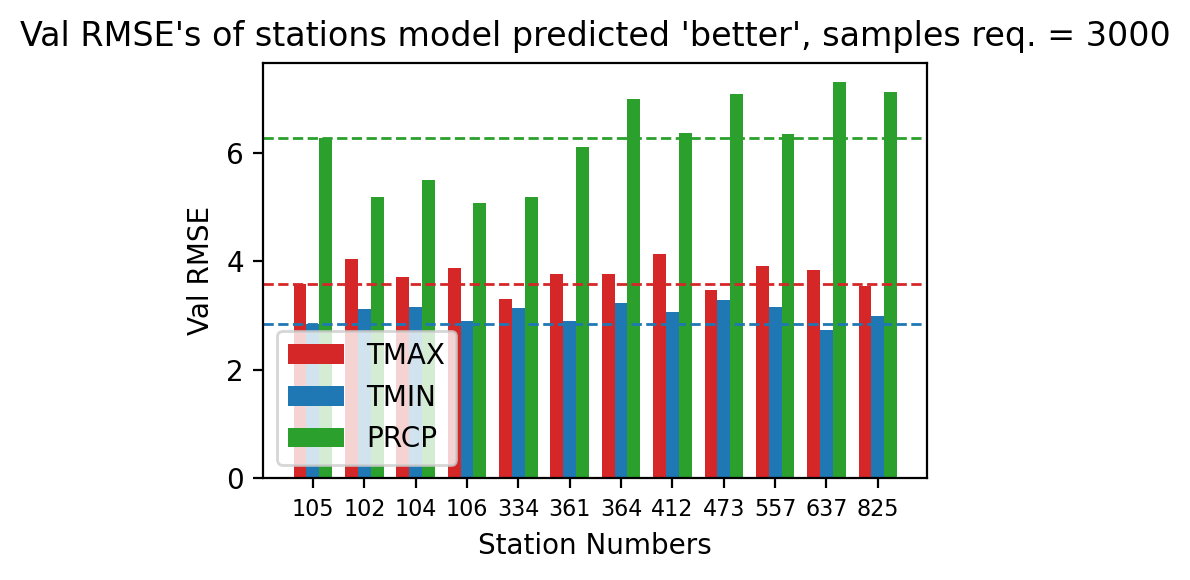

In [602]:
#plotting 
rmse_vals = np.vstack([rmse_NN, rmse_siml_stats]) #attaching main station RMSE to front of array
mns_stats = np.append(main_stat, siml_stats)

x = 2*np.arange(len(mns_stats))  # the label locations
width = 0.5  # the width of the bars

#plotting bars
fig, ax = plt.subplots(figsize=(4,3))
rect1 = ax.bar(x - width, rmse_vals[:,0], width, label='TMAX',color='C3')
rect2 = ax.bar(x, rmse_vals[:,1], width, label='TMIN',color='C0')
rect2 = ax.bar(x + width, rmse_vals[:,2], width, label='PRCP',color='C2')

#plotting lines from main station
ax.axhline(y = rmse_vals[0,0], clip_on = False,color='C3',linestyle='--',linewidth=1.0)
ax.axhline(y = rmse_vals[0,1], clip_on = False,color='C0',linestyle='--',linewidth=1.0)
ax.axhline(y = rmse_vals[0,2], clip_on = False,color='C2',linestyle='--',linewidth=1.0)

#text for labels, title and custom x-axis tick labels
ax.set_xlabel('Station Numbers')
ax.set_ylabel('Val RMSE')
ax.set_title("Val RMSE's of stations model predicted 'better', samples req. = 3000")
ax.set_xticks(x)
ax.set_xticklabels(mns_stats.astype(np.int32),size=8)
ax.legend(loc='lower left')
fig.tight_layout()

### Runnning the test to see if this method increases performance

In [463]:
#setting variables
var_names = ['TMAX','TMIN','PRCP']
main_stat = 105
sim_stats = rmse_coords[np.all(rmse_coords[:,0:3] < rmse_NN, axis=1),:][:,6]

#varying parameter
num_avgs = 10 #number of trainings to avg over
main_p = np.array([0.5,0.6,0.7,0.8,0.9,0.95,0.975,0.99,1.0])
RMSE_ratios = np.zeros((len(main_p),num_avgs,len(var_names)))
        
#loop finding avg RMSE of ratios
for i in range(len(main_p)):
    for j in range(num_avgs):
         #resetting and training the model on different data ratio
        vals = train_on_stats(var_names,siml_stats,main_stat,windowsized_opt,all_stats_data,main_p[i],batch_sized_opt)
        model_daily_opt = tuner_daily.hypermodel.build(best_hps_daily)
        history=model_daily_opt.fit(vals[0],vals[1],epochs=epochsd_opt,verbose=0,batch_size=batch_sized_opt,validation_data=(vals[2],vals[3]))
        #making predictions for the main station
        main_vals_predicted = model_daily_opt.predict(vals[4],batch_size = batch_sized_opt)
        RMSE_ratios[i,j,:] =  RMSD(main_vals_predicted,vals[5]) #storing RMSE vals for each feature        
        
        
#RMSE data to plot
RMSE_ratios_plot = np.average(RMSE_ratios,axis=1) #finding averages
sd_ratios_plot = np.sqrt(np.var(RMSE_ratios,axis=1)) #finding standard deviation
#finding averages
RMSE_ratios_plot_avg = np.average(RMSE_ratios_plot,axis=1) #finding averages
sd_ratios_plot_avg = np.average(sd_ratios_plot,axis=1) #finding standard deviation

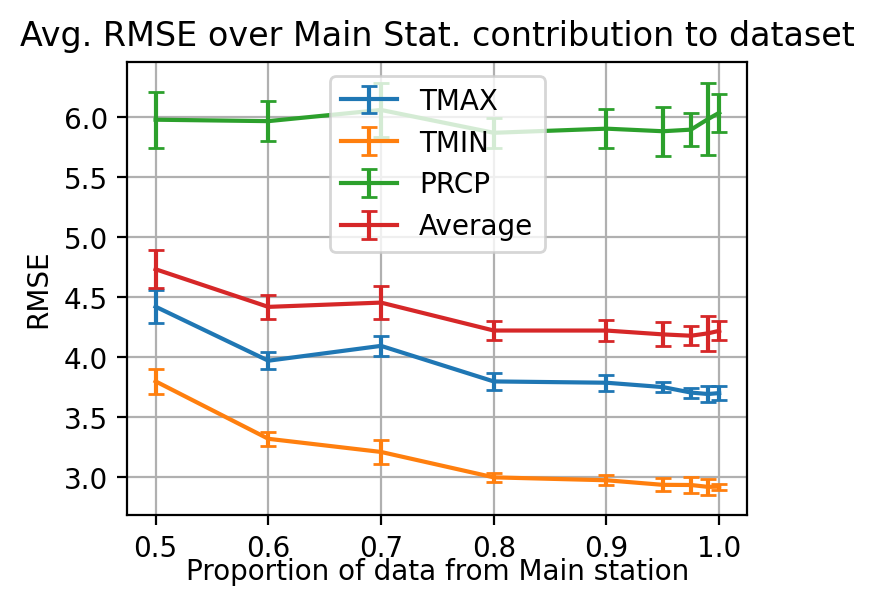

In [630]:
#plotting average RMSE over varying contribution
fig, ax = plt.subplots(figsize=(4,3))
#plotting for each weathre feature
for i in range(3):
    ax.errorbar(main_p,RMSE_ratios_plot[:,i],yerr=sd_ratios_plot[:,i],capsize =3,label=(var_names[i]))
ax.errorbar(main_p,RMSE_ratios_plot_avg,yerr=sd_ratios_plot_avg,capsize =3, label=("Average")) #plotting avg RMSE
ax.set_ylabel('RMSE')
ax.set_xlabel('Proportion of data from Main station', labelpad=-2)
ax.set_title('Avg. RMSE over Main Stat. contribution to dataset')
ax.legend()
ax.grid()